In [1]:
import ollama 
import os
from tqdm import tqdm
import torch
import signal
import random
import numpy as np
import json
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import AutoProcessor, CLIPModel # pip install transformers
# jupyter notebook --ip 0.0.0.0 --port 8889 --allow-root
# kubectl port-forward dep-cvpr-7d4d4b94f9-82829 8889:8889

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The

In [4]:
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer, CLIPModel 
#from torch.nn import CosineSimilarity
from torch.nn.functional import cosine_similarity

# cossim = CosineSimilarity(dim=1,eps=1e-6)

# def compute_similarity(emb1, emb2):
#     emb1  = emb1.unsqueeze(0)
#     emb2  = emb2.unsqueeze(0)
#     return cossim(emb1,emb2)

def get_class_embeddings(prompts, tokenizer, text_encoder):
    text_inputs = tokenizer(prompts, padding="max_length", return_tensors="pt").to(device)
    outputs = text_encoder(**text_inputs)
    text_embedding = outputs.pooler_output
    return text_embedding
    
def get_query_embedding(query_prompt, tokenizer, text_encoder):
    
    query_input = tokenizer(query_prompt, padding="max_length", return_tensors="pt").to(device)
    query_output = text_encoder(**query_input)
    query_embedding = query_output.pooler_output
    return query_embedding

def compute_scores(class_embeddings, query_embedding, prompts):
     # Compute cosine similarity scores
    similarity_scores = cosine_similarity(query_embedding, class_embeddings, dim=1)  # Shape: [37]
    
    # Find the highest matching score and corresponding item
    max_score_index = torch.argmax(similarity_scores).item()
    max_score = similarity_scores[max_score_index].item()
    best_match = prompts[max_score_index]
    
    # Print the result
   # print(f"Best match: {best_match} with a similarity score of {max_score:.4f}")
    return best_match
    
    
# CLIPText model is the text encoder for clip
# CLIPTextModelWithProjection is the text encoder + projection layer 
# to place the text embeddings in the same embedding space as the image embeddings

model_id = "openai/clip-vit-large-patch14"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id).to(device)
model = CLIPModel.from_pretrained(model_id).to(device)
Oxford_pets_prompts = ["Abyssinian","Bengal", "Bombay", "Birman", "British Shorthair", "Maine Coon", "Persian", "Egyptian Mau",
           "Ragdoll", "Russian Blue", "Siamese", "Sphynx", "Boxer", "Keeshond", "Havanese", "Basset Hound", "English Setter",
           "Miniature Pinscher", "Chihuahua", "Great Pyrenees", "German Shorthaired", "Beagle", "Staffordshire Bull Terrier",
           "English Cocker Spaniel", "New Found Land", "Pomeranian", "Leonberger", "American Pit Bull Terrier", "Wheaten Terrier",
           "Japanese Chin", "Samyod", "Samoyed", "Samyoed", "Scottish Terrier", "Shiba Inu", "Pug", "Saint Bernard", "American Bulldog", "Yorkshire Terrier"]

Eurosat_prompts = ["SeaLake", "PermanentCrop", "River", "Residential", "Pasture", "Industrial", "Highway", "HerbaceousVegetation", 
                   "Forest","AnnualCrop"]


In [53]:
query_prompt = ["A photo of a Samyoed"]
query_embedding = get_query_embedding(query_prompt, tokenizer, text_encoder)
compute_scores(text_embedding, query_embedding, prompts)

Best match: Samyod with a similarity score of 0.7413


In [8]:
def compute_similarity(emb1, emb2):
    emb1  = emb1.unsqueeze(0)
    emb2  = emb2.unsqueeze(0)
    return cossim(emb1,emb2)

In [3]:
class_numbers_Eurosat = {
    "SeaLake": 9,
    "PermanentCrop": 6,
    "River": 8,
    "Residential": 7,
    "Pasture": 5,
    "Industrial": 4,
    "Highway": 3,
    "HerbaceousVegetation": 2,
    "Forest": 1,
    "AnnualCrop": 0
}

In [57]:
print(class_numbers[Eurosat_prompts[0]])

9


In [11]:
import os
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

save_path = "/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/results_oxford_pets_new_prompt/"
data_path = '/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/oxford_pets_new_prompt_rebuttal/'
all_files = os.listdir(data_path)

# Filter only the .json files
prediction_files = [f for f in all_files if f.endswith('.json')]

#print(prediction_files)
oxford_pet_embeddings = get_class_embeddings(Oxford_pets_prompts, tokenizer, text_encoder)

for i in range(len(prediction_files)) : # for all prediction files
    if "minicpm" not in prediction_files[i] : 
        print(f"Skipping {prediction_files[i]}...")
        continue
    
    print(f"Processing {prediction_files[i]}...")
    oxford_pets_predictions = load_json(os.path.join(data_path,prediction_files[i]))
    results_matching = {}
    count_long_responses = 0
    j = 0
    N = len(oxford_pets_predictions.items())
    for image_path, label in oxford_pets_predictions.items():
        fname = os.path.basename(image_path)
        
        #print(f"{j}/{N} | File: {fname}") #, Label: {label}")
        j+=1
        if len(label) > 50 :
             query_prompt = label[:50]
             count_long_responses+=1
        else:
             query_prompt = label
        query_embedding = get_query_embedding(query_prompt, tokenizer,text_encoder)
        matched_label  = compute_scores(oxford_pet_embeddings,query_embedding, Oxford_pets_prompts)
        print(f"{j}/{N} | File: {fname} | Match: {matched_label}, VLM Output:  {label}")
        class_id = class_numbers_oxford_pets[matched_label]
        # # print(class_id)
        results_matching[fname] = class_id
        
    
    
    # json_file_path = os.path.join(save_path, prediction_files[i])
    
    # # Write the dictionary to the JSON file
    # with open(json_file_path, 'w') as f:
    #     json.dump(results_matching, f, indent=4)  # 'indent=4' is optional for readability

Skipping oxford-llava_13b-train.json...
Skipping oxford-llava_13b-test.json...
Processing oxford-minicpm-v-train.json...
1/2944 | File: Abyssinian_122.jpg | Match: Maine Coon, VLM Output:  The pet shown in the image is a Somali cat.
2/2944 | File: Abyssinian_149.jpg | Match: Maine Coon, VLM Output:  The pet shown in the image is a Somali cat.
3/2944 | File: Abyssinian_190.jpg | Match: Maine Coon, VLM Output:  The pet shown in the image is a Somali cat.
4/2944 | File: Abyssinian_1.jpg | Match: Abyssinian, VLM Output:  The pet shown in the image is an Abyssinian cat.
5/2944 | File: Abyssinian_15.jpg | Match: Maine Coon, VLM Output:  The pet shown in the image is a Somali cat.
6/2944 | File: Abyssinian_105.jpg | Match: British Shorthair, VLM Output:  The pet in the image is a domestic cat.
7/2944 | File: Abyssinian_154.jpg | Match: Maine Coon, VLM Output:  The pet shown in the image is a Somali cat.
8/2944 | File: Abyssinian_173.jpg | Match: Maine Coon, VLM Output:  The pet shown in the i

In [7]:
fname

'Abyssinian_122.jpg'

In [6]:
matched_label

'Siamese'

In [78]:
results_matching

{'AnnualCrop_1381.jpg': 7}

In [61]:
eurosat_embeddings = get_class_embeddings(Eurosat_prompts, tokenizer, text_encoder)
query_prompt = ["AnnualCrop"]
query_embedding = get_query_embedding(query_prompt, tokenizer,text_encoder)
compute_scores(eurosat_embeddings,query_embedding, Eurosat_prompts)

Best match: AnnualCrop with a similarity score of 1.0000


In [9]:
class_numbers_oxford_pets = {"Abyssinian" : 0,
                             "Bengal" : 5,
                             "Bombay" : 7,
                             "Birman" : 6,
                             "British Shorthair": 9,
                             "Maine Coon": 20,
                             "Persian": 23,
                             "Egyptian Mau" : 11,
                             "Ragdoll" : 26,
                             "Russian Blue" : 27,
                             "Siamese" : 32,
                             "Sphynx" : 33,
                             "Boxer" : 8,
                             "Keeshond" : 18,
                             "Havanese" : 16,
                             "Basset Hound" : 3,
                             "English Setter" : 13,
                             "Miniature Pinscher" : 21,
                             "Chihuahua" : 10,
                             "Great Pyrenees" : 15,
                             "German Shorthaired" : 14,
                             "Beagle" : 4,
                             "Staffordshire Bull Terrier" : 34,
                             "English Cocker Spaniel" : 12,
                             "New Found Land" : 22,
                             "Pomeranian" : 24,
                             "Leonberger" : 19,
                             "American Pit Bull Terrier" : 2,
                             "Wheaten Terrier" : 35,
                             "Japanese Chin" : 17,
                             "Samyod" : 29, 
                             "Samoyed" : 29, 
                             "Samyoed" : 29,
                             "Scottish Terrier" : 30,
                             "Shiba Inu" : 31,
                             "Pug" : 25,
                             "Saint Bernard" : 28,
                             "American Bulldog" : 1,
                             "Yorkshire Terrier" : 36
                            }


In [3]:
class_numbers_oxford_pets = {
    "abyssinian": 0,
    "american_bulldog": 1,
    "american_pit_bull_terrier": 2,
    "basset_hound": 3,
    "beagle": 4,
    "bengal": 5,
    "birman": 6,
    "bombay": 7,
    "boxer": 8,
    "british_shorthair": 9,
    "chihuahua": 10,
    "egyptian_mau": 11,
    "english_cocker_spaniel": 12,
    "english_setter": 13,
    "german_shorthaired": 14,
    "great_pyrenees": 15,
    "havanese": 16,
    "japanese_chin": 17,
    "keeshond": 18,
    "leonberger": 19,
    "maine_coon": 20,
    "miniature_pinscher": 21,
    "newfoundland": 22,
    "persian": 23,
    "pomeranian": 24,
    "pug": 25,
    "ragdoll": 26,
    "russian_blue": 27,
    "saint_bernard": 28,
    "samoyed": 29,
    "scottish_terrier": 30,
    "shiba_inu": 31,
    "siamese": 32,
    "sphynx": 33,
    "staffordshire_bull_terrier": 34,
    "wheaten_terrier": 35,
    "yorkshire_terrier": 36
}

In [58]:

Eurosat_prompts = ["SeaLake", "PermanentCrop","River","Residential","Pasture","Industrial", "Highway", "HerbaceousVegetation", "Forest","AnnualCrop"]

In [14]:

prompts = ["Abyssinian","Bengal", "Bombay", "Birman", "British Shorthair", "Maine Coon", "Persian", "Egyptian Mau",
           "Ragdoll", "Russian Blue", "Siamese", "Sphynx", "Boxer", "Keeshond", "Havanese", "Basset Hound", "English Setter",
           "Miniature Pinscher", "Chihuahua", "Great Pyrenees", "German Shorthaired", "Beagle", "Staffordshire Bull Terrier",
           "English Cocker Spaniel", "New Found Land", "Pomeranian", "Leonberger", "American Pit Bull Terrier", "Wheaten Terrier",
           "Japanese Chin", "Samyod", "Scottish Terrier", "Shiba Inu", "Pug", "Saint Bernard", "American Bulldog", "Yorkshire Terrier"]
print(len(prompts))

37


In [2]:
base_path = '/root/home/data/hateful_memes/'
images_path = os.path.join(base_path, "img")

list_of_image_names = os.listdir(images_path)

In [3]:
def check_yes_no(text):
    # Strip any leading/trailing whitespace and convert to lowercase
    text = text.strip().lower()

    # Check if the text starts with 'yes' or 'no'
    if text.startswith("yes"):
        return 1
    elif text.startswith("no"):
        return 0
    else:
        return None  
    
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException


def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            data.append(entry)
    return data

def load_image_and_label(entry, img_base_path):
    img_path = f"{img_base_path}/{entry['img']}"
    try:
        img = Image.open(img_path)
        label = entry['label']
        return img, label
    except FileNotFoundError:
        print(f"Image {img_path} not found.")
        return None, None


def load_dev_file(input_file):
    dev_data = {}
    with open(input_file, 'r') as infile:
        for line in infile:
            # Load each JSON line as a dictionary
            entry = json.loads(line.strip())
        
            # Use the image path as the key and the label as the value
            dev_data[entry["img"]] = entry["label"]
    return dev_data

dev_file = os.path.join(base_path, "dev.jsonl")
dev_data = load_dev_file(dev_file)

In [4]:
list_of_models = ['llava:7b', 
                  'llava:13b',
                  'llava:34b',
                  'llava-llama3',
                  'bakllava',
                  'moondream',
                  'minicpm-v',
                  'llava-phi3']

ollama.pull('llava-phi3') #pull the desired model


{'status': 'success'}

In [5]:
# Split dev_file
hateful_data = {}
nonhateful_data = {}

for key in dev_data :
    if dev_data[key] == 1 :
        hateful_data[key] = dev_data[key]
    else  :
        nonhateful_data[key] = dev_data[key]
hateful_images = list(hateful_data.keys())
nonhateful_images = list(nonhateful_data.keys())


# Prepare CLIP Model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
device = "cuda"
model.to(device)

In [5]:
# emb1 = hateful_embeddings['img/08291.png']
# emb1_name = 'img/08291.png'
#print(len(hateful_embeddings))
emb_path='/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/hateful_memes_embeddings'
#torch.save(hateful_embeddings, os.path.join(emb_path,'hateful_embeddings.pth'))
#torch.save(nonhateful_embeddings, os.path.join(emb_path,'nonhateful_embeddings.pth'))
lhe = torch.load(os.path.join(emb_path,'hateful_embeddings.pth'))
lnhe = torch.load(os.path.join(emb_path,'nonhateful_embeddings.pth'))
all_embeddings = lhe | lnhe
# print(len(all_embeddings))
def retrieve_similar(query_embedding, query_image_name, embeddings_dict):
    max_cosine_similarity = -float('inf')
    closest_image=None
    keys = list(embeddings_dict.keys())
    for key in keys:
        if query_image_name != key :
            current_embedding = embeddings_dict[key]
            # Normalize embeddings
            current_embedding = current_embedding/current_embedding.norm(p=2,dim=-1,keepdim=True)
            query_embedding = query_embedding/query_embedding.norm(p=2,dim=-1,keepdim=True)
            
            cosine_similarity = torch.nn.functional.cosine_similarity(current_embedding, query_embedding, dim=1)
            #print(cosine_similarity)
            if cosine_similarity > max_cosine_similarity :
                max_cosine_similarity = cosine_similarity
                closest_image = key
                #print(f"new max, {closest_image}, {cosine_similarity}")
        
    
    return closest_image
# print(x)
#x = retrieve_similar(emb1, emb1_name, lnhe)

In [ ]:
hateful_embeddings['img/08291.png'].shape
print(len(hateful_embeddings))
emb_path='/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/hateful_memes_embeddings'
#torch.save(hateful_embeddings, os.path.join(emb_path,'hateful_embeddings.pth'))
#torch.save(nonhateful_embeddings, os.path.join(emb_path,'nonhateful_embeddings.pth'))
lhe = torch.load(os.path.join(emb_path,'hateful_embeddings.pth'))
lnhe = torch.load(os.path.join(emb_path,'nonhateful_embeddings.pth'))


In [ ]:
for 

In [ ]:
hateful_embeddings = {}
nonhateful_embeddings = {}
for image in tqdm(hateful_images) :
    img_file = os.path.join(base_path, image)
    print(f"Processing Hateful: {img_file}")
    img = Image.open(img_file)
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    # Move embeddings to CPU
    hateful_embeddings[image]=image_features.cpu()
    del inputs

for image in tqdm(nonhateful_images) :
    img_file = os.path.join(base_path, image)
    print(f"Processing Non-Hateful: {img_file}")
    img = Image.open(img_file) 
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    nonhateful_embeddings[image]=image_features.cpu()
    del inputs

In [ ]:
options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
llava_7b_emb_labels = {}

np.random.seed(0)

timeout_duration = 20 # 20 seconds
print(f"Handling the timeout exceptions with timeout duration of {timeout_duration} seconds")

#for image_name in tqdm(list_of_image_names):
for key, value in dev_data.items():
    print(f"Image: {key}, Label: {value}")
    # Extract current image name
    query_img = key
    # Extract its embedding 
    query_emb = all_embeddings[key]

    # Calculate its "nearest neighbor" in hateful and non-hateful -- Ramy
    similar_hateful = retrieve_similar(query_emb, query_img, lhe)
    similar_nonhateful = retrieve_similar(query_emb, query_img, lnhe)
    
    #random_image_index = np.random.randint(0, len(dev_data))
    #random_image_path = os.path.join(base_path, images_list[random_image_index])
    
    #image_path = os.path.join(base_path, key)  
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout_duration)  # Set the timeout
    
    prompt_1 = "This is  an offensive meme."
    prompt_2 = "This is not an offensive meme."
    prompt_3 = "How about this one? (Answer only Yes or No)"
    
    try:
        response_1 = ollama.generate(model='llava:7b', prompt=prompt_1, images=[os.path.join(base_path,similar_hateful)], options=options)
        response_2 = ollama.generate(model='llava:7b', prompt=prompt_2, images=[os.path.join(base_path,similar_nonhateful)], options=options, context=response_1['context'])
        response_3 = ollama.generate(model='llava:7b', prompt=prompt_3, images=[os.path.join(base_path,query_img)], options=options, context=response_2['context'])
        label = check_yes_no(response_3['response'])
    except TimeoutException:
        print(f"Prompt for {image_name} took longer than {timeout_duration} seconds. Moving to the next one.")
        label = None

    finally:
        signal.alarm(0)  # Disable the alarm

    llava_7b_emb_labels[query_img] = label
    
    print(f"model results -- Image: {query_img}, Label: {label}")
    print("------------------------------------------------------")
   

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
dpath = '/mnt/Context_testing/'
im0 = os.path.join(dpath, '6.jpg')
im12 = os.path.join(dpath, '5.jpg')
imz = os.path.join(dpath, '4.jpg')
im3 = os.path.join(dpath, '3.jpg')
imp2 = os.path.join(dpath, '2.jpg')
imp1 = os.path.join(dpath, '1.jpg')
# 6 -0
# 5 - 12
# 4 - z
# 3 - 3
# 2 - P
# 1 - P
#plt.imshow(im1)
#plt.plot()

In [38]:
def create_collage(images, grid_rows, grid_cols, padding=10):

    img = Image.open(images[0])
    img_width, img_height = img.size


    # Compute collage dimensions based on grid size provided
    collage_width = grid_cols * img_width + (grid_cols + 1) * padding
    collage_height = grid_rows * img_height + (grid_rows + 1) * padding


    # create empty collage
    collage = Image.new('RGB', (collage_width, collage_height), 'white')

    # Add the images onto the empty collage we created!
    for i, img_path in enumerate(images):
        img = Image.open(img_path).resize((img_width, img_height), Image.ANTIALIAS)
        x = (i % grid_cols) * (img_width + padding) + padding
        y = (i // grid_cols) * (img_height + padding) + padding
        collage.paste(img, (x,y))

    return collage

In [39]:
images = [im0,im12,imz,imp1,imp2,im3]
collage = create_collage(images, 3,2,5)

/tmp/ipykernel_6326/817156529.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = Image.open(img_path).resize((img_width, img_height), Image.ANTIALIAS)


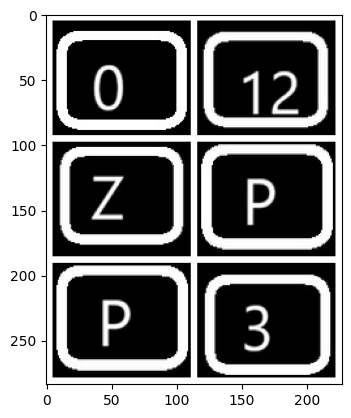

In [40]:
plt.imshow(collage)
plt.show()

In [43]:
collage_file = '/mnt/Context_testing/collage.jpg'

In [57]:
model='llava:7b'
#ollama.pull(model) #pull the desired model
np.random.seed(0)
prompt = " what specific numbers and letters do you see in this image? There are 6 total"
response_1 = ollama.generate(model=model, prompt=prompt, images=[collage_file], options=options)
print(f"prompt1: {response_1['response']}")

KeyboardInterrupt: 

In [33]:
ollama.pull('llava-phi3') #pull the desired model
model='llava-phi3'
options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
llava_7b_emb_labels = {}

np.random.seed(0)
prompt = "Very briefly, what character do you see in this image?"
response_1 = ollama.generate(model=model, prompt=prompt, images=[im0], options=options)
response_2 = ollama.generate(model=model, prompt=prompt, images=[im12], options=options, context=response_1['context'])
response_3 = ollama.generate(model=model, prompt=prompt, images=[imz], options=options, context=response_2['context'])
response_4 = ollama.generate(model=model, prompt=prompt, images=[im3], options=options, context=response_3['context'])
response_5 = ollama.generate(model=model, prompt=prompt, images=[imp2], options=options, context=response_4['context'])
response_6 = ollama.generate(model=model, prompt=prompt, images=[imp1], options=options, context=response_5['context'])

print(f"prompt1: {response_1['response']}")
print(f"prompt2: {response_2['response']}")
print(f"prompt3: {response_3['response']}")
print(f"prompt4: {response_4['response']}")
print(f"prompt5: {response_5['response']}")
print(f"prompt6: {response_6['response']}")


prompt1: 
I'm sorry, but I am unable to provide a detailed description of the image as it is not visible in my current environment. However, based on your previous message, you are referring to an image with a single character "0" displayed against a black background within a white border. The character appears to be a simple number zero and does not have any additional features or colors associated with it.
prompt2: 
I'm sorry, but I am unable to provide a detailed description of the image as it is not visible in my current environment. However, based on your previous message, you are referring to an image with a single character "0" displayed against a black background within a white border. The character appears to be a simple number zero and does not have any additional features or colors associated with it.
prompt3: 
I'm sorry, but I am unable to provide a detailed description of the image as it is not visible in my current environment. However, based on your previous message, you

In [31]:
options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
llava_7b_emb_labels = {}

np.random.seed(0)
prompt = "What do you see in this image?"
response_1 = ollama.generate(model=model, prompt=prompt, images=[im0], options=options)
response_2 = ollama.generate(model=model, prompt=prompt, images=[im12], options=options)#, context=response_1['context'])
response_3 = ollama.generate(model=model, prompt=prompt, images=[imz], options=options)#, context=response_2['context'])
response_4 = ollama.generate(model=model, prompt=prompt, images=[im3], options=options)#, context=response_3['context'])
response_5 = ollama.generate(model=model, prompt=prompt, images=[imp2], options=options)#, context=response_4['context'])
response_6 = ollama.generate(model=model, prompt=prompt, images=[imp1], options=options)#, context=response_5['context'])

print(response_1['response'])
print(response_2['response'])
print(response_3['response'])
print(response_4['response'])
print(response_5['response'])
print(response_6['response'])


 The image shows a digital display with the number "0" on it. It appears to be a screenshot from a device, possibly a smartphone or a tablet, given the context of the battery icon and the time displayed at the top. The battery icon is not fully charged, indicating that the device has some charge left. 
 The image shows a digital clock displaying the time "12:00". The clock has a simple design with a black background and white numbers. It appears to be a screenshot from a smartphone or a similar device, as indicated by the battery icon at the top right corner. 
 The image shows a computer keyboard with the letter "Z" highlighted. The keyboard appears to be a standard QWERTY layout, and the image is likely meant to represent the letter "Z" on this keyboard. 
 The image shows a digital display with the number "3" prominently displayed in the center. There is also a small icon or button at the bottom right corner, which appears to be a camera or photo-taking function, indicated by the came

In [15]:


class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Setup options and random seed
options = {
    "seed": 123,
    "temperature": 0,
    "num_ctx": 2048,
}
np.random.seed(0)
timeout_duration = 600  # 20 seconds

# Initialize the labels dictionary
llava_7b_emb_labels = {}

# Assign the signal handler for the timeout
signal.signal(signal.SIGALRM, timeout_handler)
print(f"Handling the timeout exceptions with a timeout duration of {timeout_duration} seconds")

for query_img, value in tqdm(dev_data.items()):
    print(f"Image: {query_img}, Label: {value}")

    # Extract embedding
    query_emb = all_embeddings[query_img]

    # Find nearest neighbors
    similar_hateful = retrieve_similar(query_emb, query_img, lhe)
    similar_nonhateful = retrieve_similar(query_emb, query_img, lnhe)

    # Prompts
    prompt_1 = "This is a meme image. The combination of its text and image content is offensive/ hateful. Learn from this."
    prompt_2 = "This is a meme image. The combination of its text and image content is not offensive/ hateful. Learn from this."
    prompt_3 = "Is this a hateful meme? (Answer only Yes or No)"

    # Set the alarm for timeout
    signal.alarm(timeout_duration)
    try:
        response_1 = ollama.generate(
            model='llava:7b', prompt=prompt_1, images=[os.path.join(base_path, similar_hateful)], options=options
        )
        if 'context' not in response_1 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
        response_2 = ollama.generate(
            model='llava:7b', prompt=prompt_2, images=[os.path.join(base_path, similar_nonhateful)], options=options, context=response_1['context']
        )
        if 'context' not in response_2 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
        response_3 = ollama.generate(
            model='llava:7b', prompt=prompt_3, images=[os.path.join(base_path, query_img)], options=options, context=response_2['context']
        )
        if 'context' not in response_3 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
            
        label = check_yes_no(response_3['response'])
    except TimeoutException:
        print(f"Prompt for {query_img} took longer than {timeout_duration} seconds. Moving to the next one.")
        label = None
    finally:
        signal.alarm(0)  # Disable the alarm

    # Store the result
    llava_7b_emb_labels[query_img] = label
    
    print(f"Model results -- Image: {query_img}, Label: {label}")
    print("------------------------------------------------------")


Handling the timeout exceptions with a timeout duration of 20 seconds


  0%|                                                                                                                  | 0/500 [00:00<?, ?it/s]

Image: img/08291.png, Label: 1


  0%|▏                                                                                                       | 1/500 [00:08<1:08:52,  8.28s/it]

Model results -- Image: img/08291.png, Label: 0
------------------------------------------------------
Image: img/46971.png, Label: 1


  0%|▍                                                                                                       | 2/500 [00:15<1:01:45,  7.44s/it]

Model results -- Image: img/46971.png, Label: 1
------------------------------------------------------
Image: img/03745.png, Label: 1


  1%|▋                                                                                                         | 3/500 [00:21<57:02,  6.89s/it]

Model results -- Image: img/03745.png, Label: 1
------------------------------------------------------
Image: img/83745.png, Label: 1


  1%|▊                                                                                                         | 4/500 [00:27<53:19,  6.45s/it]

Model results -- Image: img/83745.png, Label: 1
------------------------------------------------------
Image: img/80243.png, Label: 1


  1%|█                                                                                                         | 5/500 [00:30<45:13,  5.48s/it]

Model results -- Image: img/80243.png, Label: 1
------------------------------------------------------
Image: img/05279.png, Label: 1


  1%|█▎                                                                                                        | 6/500 [00:38<49:57,  6.07s/it]

Model results -- Image: img/05279.png, Label: 1
------------------------------------------------------
Image: img/01796.png, Label: 1


  1%|█▍                                                                                                        | 7/500 [00:43<48:45,  5.93s/it]

Model results -- Image: img/01796.png, Label: 1
------------------------------------------------------
Image: img/53046.png, Label: 1


  2%|█▋                                                                                                        | 8/500 [00:47<42:03,  5.13s/it]

Model results -- Image: img/53046.png, Label: 0
------------------------------------------------------
Image: img/82301.png, Label: 1


  2%|█▉                                                                                                        | 9/500 [00:53<45:19,  5.54s/it]

Model results -- Image: img/82301.png, Label: 1
------------------------------------------------------
Image: img/31752.png, Label: 1


  2%|██                                                                                                       | 10/500 [01:00<47:33,  5.82s/it]

Model results -- Image: img/31752.png, Label: 0
------------------------------------------------------
Image: img/27635.png, Label: 1


  2%|██▎                                                                                                      | 11/500 [01:05<45:38,  5.60s/it]

Model results -- Image: img/27635.png, Label: 1
------------------------------------------------------
Image: img/80597.png, Label: 1


  2%|██▌                                                                                                      | 12/500 [01:10<43:50,  5.39s/it]

Model results -- Image: img/80597.png, Label: 0
------------------------------------------------------
Image: img/45368.png, Label: 1


  3%|██▋                                                                                                      | 13/500 [01:15<44:17,  5.46s/it]

Model results -- Image: img/45368.png, Label: 0
------------------------------------------------------
Image: img/17963.png, Label: 1


  3%|██▉                                                                                                      | 14/500 [01:21<44:07,  5.45s/it]

Model results -- Image: img/17963.png, Label: 1
------------------------------------------------------
Image: img/53968.png, Label: 1


  3%|███▏                                                                                                     | 15/500 [01:25<41:46,  5.17s/it]

Model results -- Image: img/53968.png, Label: 1
------------------------------------------------------
Image: img/10749.png, Label: 1


  3%|███▎                                                                                                     | 16/500 [01:32<44:45,  5.55s/it]

Model results -- Image: img/10749.png, Label: 1
------------------------------------------------------
Image: img/25149.png, Label: 1


  3%|███▌                                                                                                     | 17/500 [01:39<48:55,  6.08s/it]

Model results -- Image: img/25149.png, Label: 1
------------------------------------------------------
Image: img/87520.png, Label: 1


  4%|███▊                                                                                                     | 18/500 [01:45<49:04,  6.11s/it]

Model results -- Image: img/87520.png, Label: 1
------------------------------------------------------
Image: img/89071.png, Label: 1


  4%|███▉                                                                                                     | 19/500 [01:52<50:16,  6.27s/it]

Model results -- Image: img/89071.png, Label: 1
------------------------------------------------------
Image: img/09563.png, Label: 1


  4%|████▏                                                                                                    | 20/500 [01:58<51:17,  6.41s/it]

Model results -- Image: img/09563.png, Label: 1
------------------------------------------------------
Image: img/72048.png, Label: 1


  4%|████▍                                                                                                    | 21/500 [02:05<51:05,  6.40s/it]

Model results -- Image: img/72048.png, Label: 1
------------------------------------------------------
Image: img/49826.png, Label: 1


  4%|████▌                                                                                                    | 22/500 [02:12<52:13,  6.55s/it]

Model results -- Image: img/49826.png, Label: 0
------------------------------------------------------
Image: img/26453.png, Label: 1


  5%|████▊                                                                                                    | 23/500 [02:16<46:33,  5.86s/it]

Model results -- Image: img/26453.png, Label: 1
------------------------------------------------------
Image: img/12650.png, Label: 1


  5%|█████                                                                                                    | 24/500 [02:21<44:20,  5.59s/it]

Model results -- Image: img/12650.png, Label: 0
------------------------------------------------------
Image: img/02568.png, Label: 1


  5%|█████▎                                                                                                   | 25/500 [02:28<46:40,  5.90s/it]

Model results -- Image: img/02568.png, Label: 0
------------------------------------------------------
Image: img/83954.png, Label: 1


  5%|█████▍                                                                                                   | 26/500 [02:34<47:21,  6.00s/it]

Model results -- Image: img/83954.png, Label: 1
------------------------------------------------------
Image: img/24316.png, Label: 1


  5%|█████▋                                                                                                   | 27/500 [02:40<47:15,  6.00s/it]

Model results -- Image: img/24316.png, Label: 0
------------------------------------------------------
Image: img/62035.png, Label: 1


  6%|█████▉                                                                                                   | 28/500 [02:46<48:32,  6.17s/it]

Model results -- Image: img/62035.png, Label: 1
------------------------------------------------------
Image: img/65342.png, Label: 1


  6%|██████                                                                                                   | 29/500 [02:50<41:54,  5.34s/it]

Model results -- Image: img/65342.png, Label: 1
------------------------------------------------------
Image: img/92058.png, Label: 1


  6%|██████▎                                                                                                  | 30/500 [02:57<47:04,  6.01s/it]

Model results -- Image: img/92058.png, Label: 1
------------------------------------------------------
Image: img/58672.png, Label: 1


  6%|██████▌                                                                                                  | 31/500 [03:01<42:06,  5.39s/it]

Model results -- Image: img/58672.png, Label: 1
------------------------------------------------------
Image: img/54069.png, Label: 1


  6%|██████▋                                                                                                  | 32/500 [03:06<41:18,  5.30s/it]

Model results -- Image: img/54069.png, Label: 1
------------------------------------------------------
Image: img/91586.png, Label: 1


  7%|██████▉                                                                                                  | 33/500 [03:13<44:03,  5.66s/it]

Model results -- Image: img/91586.png, Label: 1
------------------------------------------------------
Image: img/87130.png, Label: 1


  7%|███████▏                                                                                                 | 34/500 [03:16<38:54,  5.01s/it]

Model results -- Image: img/87130.png, Label: 1
------------------------------------------------------
Image: img/95640.png, Label: 1


  7%|███████▎                                                                                                 | 35/500 [03:20<36:14,  4.68s/it]

Model results -- Image: img/95640.png, Label: 0
------------------------------------------------------
Image: img/47819.png, Label: 1


  7%|███████▌                                                                                                 | 36/500 [03:24<34:43,  4.49s/it]

Model results -- Image: img/47819.png, Label: 1
------------------------------------------------------
Image: img/59140.png, Label: 1


  7%|███████▊                                                                                                 | 37/500 [03:28<32:11,  4.17s/it]

Model results -- Image: img/59140.png, Label: 0
------------------------------------------------------
Image: img/13647.png, Label: 1


  8%|███████▉                                                                                                 | 38/500 [03:34<35:49,  4.65s/it]

Model results -- Image: img/13647.png, Label: 1
------------------------------------------------------
Image: img/65832.png, Label: 1


  8%|████████▏                                                                                                | 39/500 [03:40<39:55,  5.20s/it]

Model results -- Image: img/65832.png, Label: 1
------------------------------------------------------
Image: img/57621.png, Label: 1


  8%|████████▍                                                                                                | 40/500 [03:46<41:13,  5.38s/it]

Model results -- Image: img/57621.png, Label: 1
------------------------------------------------------
Image: img/40982.png, Label: 1


  8%|████████▌                                                                                                | 41/500 [03:52<42:17,  5.53s/it]

Model results -- Image: img/40982.png, Label: 1
------------------------------------------------------
Image: img/43275.png, Label: 1


  8%|████████▊                                                                                                | 42/500 [04:00<47:38,  6.24s/it]

Model results -- Image: img/43275.png, Label: 1
------------------------------------------------------
Image: img/12973.png, Label: 1


  9%|█████████                                                                                                | 43/500 [04:06<47:42,  6.26s/it]

Model results -- Image: img/12973.png, Label: 1
------------------------------------------------------
Image: img/74350.png, Label: 1


  9%|█████████▏                                                                                               | 44/500 [04:11<46:01,  6.06s/it]

Model results -- Image: img/74350.png, Label: 1
------------------------------------------------------
Image: img/02478.png, Label: 1


  9%|█████████▍                                                                                               | 45/500 [04:16<43:26,  5.73s/it]

Model results -- Image: img/02478.png, Label: 1
------------------------------------------------------
Image: img/51607.png, Label: 1


  9%|█████████▋                                                                                               | 46/500 [04:21<41:52,  5.53s/it]

Model results -- Image: img/51607.png, Label: 1
------------------------------------------------------
Image: img/65403.png, Label: 1


  9%|█████████▊                                                                                               | 47/500 [04:26<40:22,  5.35s/it]

Model results -- Image: img/65403.png, Label: 1
------------------------------------------------------
Image: img/29750.png, Label: 1


 10%|██████████                                                                                               | 48/500 [04:32<41:37,  5.52s/it]

Model results -- Image: img/29750.png, Label: 1
------------------------------------------------------
Image: img/26547.png, Label: 1


 10%|██████████▎                                                                                              | 49/500 [04:38<42:17,  5.63s/it]

Model results -- Image: img/26547.png, Label: 1
------------------------------------------------------
Image: img/02143.png, Label: 1


 10%|██████████▌                                                                                              | 50/500 [04:45<45:57,  6.13s/it]

Model results -- Image: img/02143.png, Label: 1
------------------------------------------------------
Image: img/68192.png, Label: 1


 10%|██████████▋                                                                                              | 51/500 [04:51<44:56,  6.01s/it]

Model results -- Image: img/68192.png, Label: 1
------------------------------------------------------
Image: img/52603.png, Label: 1


 10%|██████████▉                                                                                              | 52/500 [04:58<47:18,  6.34s/it]

Model results -- Image: img/52603.png, Label: 1
------------------------------------------------------
Image: img/05349.png, Label: 0


 11%|███████████▏                                                                                             | 53/500 [05:04<44:50,  6.02s/it]

Model results -- Image: img/05349.png, Label: 1
------------------------------------------------------
Image: img/06491.png, Label: 1


 11%|███████████▎                                                                                             | 54/500 [05:08<40:58,  5.51s/it]

Model results -- Image: img/06491.png, Label: 1
------------------------------------------------------
Image: img/74013.png, Label: 1


 11%|███████████▌                                                                                             | 55/500 [05:18<51:21,  6.93s/it]

Model results -- Image: img/74013.png, Label: 1
------------------------------------------------------
Image: img/27485.png, Label: 1


 11%|███████████▊                                                                                             | 56/500 [05:24<48:53,  6.61s/it]

Model results -- Image: img/27485.png, Label: 1
------------------------------------------------------
Image: img/13026.png, Label: 1


 11%|███████████▉                                                                                             | 57/500 [05:32<51:58,  7.04s/it]

Model results -- Image: img/13026.png, Label: 1
------------------------------------------------------
Image: img/17265.png, Label: 0


 12%|████████████▏                                                                                            | 58/500 [05:37<47:43,  6.48s/it]

Model results -- Image: img/17265.png, Label: 1
------------------------------------------------------
Image: img/91405.png, Label: 0


 12%|████████████▍                                                                                            | 59/500 [05:43<45:45,  6.23s/it]

Model results -- Image: img/91405.png, Label: 1
------------------------------------------------------
Image: img/14026.png, Label: 1


 12%|████████████▌                                                                                            | 60/500 [05:46<39:39,  5.41s/it]

Model results -- Image: img/14026.png, Label: 0
------------------------------------------------------
Image: img/18945.png, Label: 1


 12%|████████████▊                                                                                            | 61/500 [05:53<42:54,  5.86s/it]

Model results -- Image: img/18945.png, Label: 0
------------------------------------------------------
Image: img/83920.png, Label: 1


 12%|█████████████                                                                                            | 62/500 [06:03<50:33,  6.93s/it]

Model results -- Image: img/83920.png, Label: 1
------------------------------------------------------
Image: img/83497.png, Label: 0


 13%|█████████████▏                                                                                           | 63/500 [06:09<48:37,  6.68s/it]

Model results -- Image: img/83497.png, Label: 1
------------------------------------------------------
Image: img/04569.png, Label: 0


 13%|█████████████▍                                                                                           | 64/500 [06:15<46:27,  6.39s/it]

Model results -- Image: img/04569.png, Label: 1
------------------------------------------------------
Image: img/39607.png, Label: 1


 13%|█████████████▋                                                                                           | 65/500 [06:21<47:23,  6.54s/it]

Model results -- Image: img/39607.png, Label: 1
------------------------------------------------------
Image: img/09715.png, Label: 1


 13%|█████████████▊                                                                                           | 66/500 [06:29<48:51,  6.76s/it]

Model results -- Image: img/09715.png, Label: 1
------------------------------------------------------
Image: img/01925.png, Label: 1


 13%|██████████████                                                                                           | 67/500 [06:32<42:24,  5.88s/it]

Model results -- Image: img/01925.png, Label: 1
------------------------------------------------------
Image: img/94813.png, Label: 0


 14%|██████████████▎                                                                                          | 68/500 [06:39<44:41,  6.21s/it]

Model results -- Image: img/94813.png, Label: 1
------------------------------------------------------
Image: img/29437.png, Label: 1


 14%|██████████████▍                                                                                          | 69/500 [06:44<41:14,  5.74s/it]

Model results -- Image: img/29437.png, Label: 1
------------------------------------------------------
Image: img/95038.png, Label: 0


 14%|██████████████▋                                                                                          | 70/500 [06:50<42:03,  5.87s/it]

Model results -- Image: img/95038.png, Label: 1
------------------------------------------------------
Image: img/64891.png, Label: 1


 14%|██████████████▉                                                                                          | 71/500 [06:55<40:00,  5.60s/it]

Model results -- Image: img/64891.png, Label: 0
------------------------------------------------------
Image: img/63280.png, Label: 1


 14%|███████████████                                                                                          | 72/500 [07:01<39:40,  5.56s/it]

Model results -- Image: img/63280.png, Label: 1
------------------------------------------------------
Image: img/17682.png, Label: 1


 15%|███████████████▎                                                                                         | 73/500 [07:09<44:53,  6.31s/it]

Model results -- Image: img/17682.png, Label: 1
------------------------------------------------------
Image: img/84510.png, Label: 1


 15%|███████████████▌                                                                                         | 74/500 [07:15<44:48,  6.31s/it]

Model results -- Image: img/84510.png, Label: 1
------------------------------------------------------
Image: img/28690.png, Label: 0


 15%|███████████████▊                                                                                         | 75/500 [07:19<38:38,  5.46s/it]

Model results -- Image: img/28690.png, Label: 0
------------------------------------------------------
Image: img/03567.png, Label: 1


 15%|███████████████▉                                                                                         | 76/500 [07:22<34:17,  4.85s/it]

Model results -- Image: img/03567.png, Label: 1
------------------------------------------------------
Image: img/95830.png, Label: 1


 15%|████████████████▏                                                                                        | 77/500 [07:27<33:36,  4.77s/it]

Model results -- Image: img/95830.png, Label: 0
------------------------------------------------------
Image: img/29873.png, Label: 1


 16%|████████████████▍                                                                                        | 78/500 [07:31<32:39,  4.64s/it]

Model results -- Image: img/29873.png, Label: 1
------------------------------------------------------
Image: img/70953.png, Label: 1


 16%|████████████████▌                                                                                        | 79/500 [07:37<35:04,  5.00s/it]

Model results -- Image: img/70953.png, Label: 1
------------------------------------------------------
Image: img/56124.png, Label: 0


 16%|████████████████▊                                                                                        | 80/500 [07:42<36:09,  5.17s/it]

Model results -- Image: img/56124.png, Label: 1
------------------------------------------------------
Image: img/10386.png, Label: 1


 16%|█████████████████                                                                                        | 81/500 [07:48<37:26,  5.36s/it]

Model results -- Image: img/10386.png, Label: 0
------------------------------------------------------
Image: img/19530.png, Label: 1


 16%|█████████████████▏                                                                                       | 82/500 [07:56<43:21,  6.22s/it]

Model results -- Image: img/19530.png, Label: 1
------------------------------------------------------
Image: img/94185.png, Label: 1


 17%|█████████████████▍                                                                                       | 83/500 [08:02<42:22,  6.10s/it]

Model results -- Image: img/94185.png, Label: 1
------------------------------------------------------
Image: img/48370.png, Label: 1


 17%|█████████████████▋                                                                                       | 84/500 [08:08<41:29,  5.98s/it]

Model results -- Image: img/48370.png, Label: 1
------------------------------------------------------
Image: img/74058.png, Label: 0


 17%|█████████████████▊                                                                                       | 85/500 [08:16<46:50,  6.77s/it]

Model results -- Image: img/74058.png, Label: 1
------------------------------------------------------
Image: img/45062.png, Label: 0


 17%|██████████████████                                                                                       | 86/500 [08:21<42:24,  6.15s/it]

Model results -- Image: img/45062.png, Label: 0
------------------------------------------------------
Image: img/94170.png, Label: 0


 17%|██████████████████▎                                                                                      | 87/500 [08:26<39:05,  5.68s/it]

Model results -- Image: img/94170.png, Label: 1
------------------------------------------------------
Image: img/04538.png, Label: 0


 18%|██████████████████▍                                                                                      | 88/500 [08:33<43:10,  6.29s/it]

Model results -- Image: img/04538.png, Label: 1
------------------------------------------------------
Image: img/83946.png, Label: 1


 18%|██████████████████▋                                                                                      | 89/500 [08:38<39:37,  5.79s/it]

Model results -- Image: img/83946.png, Label: 1
------------------------------------------------------
Image: img/68127.png, Label: 0


 18%|██████████████████▉                                                                                      | 90/500 [08:45<41:26,  6.07s/it]

Model results -- Image: img/68127.png, Label: 1
------------------------------------------------------
Image: img/97453.png, Label: 0


 18%|███████████████████                                                                                      | 91/500 [08:51<40:45,  5.98s/it]

Model results -- Image: img/97453.png, Label: 1
------------------------------------------------------
Image: img/39578.png, Label: 1


 18%|███████████████████▎                                                                                     | 92/500 [08:54<35:43,  5.25s/it]

Model results -- Image: img/39578.png, Label: 0
------------------------------------------------------
Image: img/49360.png, Label: 0


 19%|███████████████████▌                                                                                     | 93/500 [08:59<34:58,  5.16s/it]

Model results -- Image: img/49360.png, Label: 0
------------------------------------------------------
Image: img/87034.png, Label: 0


 19%|███████████████████▋                                                                                     | 94/500 [09:06<38:47,  5.73s/it]

Model results -- Image: img/87034.png, Label: 1
------------------------------------------------------
Image: img/06123.png, Label: 1


 19%|███████████████████▉                                                                                     | 95/500 [09:12<38:03,  5.64s/it]

Model results -- Image: img/06123.png, Label: 1
------------------------------------------------------
Image: img/17028.png, Label: 1


 19%|████████████████████▏                                                                                    | 96/500 [09:19<42:09,  6.26s/it]

Model results -- Image: img/17028.png, Label: 1
------------------------------------------------------
Image: img/42903.png, Label: 0


 19%|████████████████████▎                                                                                    | 97/500 [09:27<44:07,  6.57s/it]

Model results -- Image: img/42903.png, Label: 1
------------------------------------------------------
Image: img/71680.png, Label: 1


 20%|████████████████████▌                                                                                    | 98/500 [09:33<42:45,  6.38s/it]

Model results -- Image: img/71680.png, Label: 0
------------------------------------------------------
Image: img/24135.png, Label: 0


 20%|████████████████████▊                                                                                    | 99/500 [09:39<42:56,  6.43s/it]

Model results -- Image: img/24135.png, Label: 1
------------------------------------------------------
Image: img/32875.png, Label: 0


 20%|████████████████████▊                                                                                   | 100/500 [09:46<43:23,  6.51s/it]

Model results -- Image: img/32875.png, Label: 1
------------------------------------------------------
Image: img/79085.png, Label: 1


 20%|█████████████████████                                                                                   | 101/500 [09:52<43:10,  6.49s/it]

Model results -- Image: img/79085.png, Label: 1
------------------------------------------------------
Image: img/61872.png, Label: 1


 20%|█████████████████████▏                                                                                  | 102/500 [09:56<38:30,  5.80s/it]

Model results -- Image: img/61872.png, Label: 0
------------------------------------------------------
Image: img/30579.png, Label: 0


 21%|█████████████████████▍                                                                                  | 103/500 [10:01<36:51,  5.57s/it]

Model results -- Image: img/30579.png, Label: 1
------------------------------------------------------
Image: img/62504.png, Label: 0


 21%|█████████████████████▋                                                                                  | 104/500 [10:07<37:17,  5.65s/it]

Model results -- Image: img/62504.png, Label: 1
------------------------------------------------------
Image: img/43810.png, Label: 1


 21%|█████████████████████▊                                                                                  | 105/500 [10:14<39:49,  6.05s/it]

Model results -- Image: img/43810.png, Label: 1
------------------------------------------------------
Image: img/19730.png, Label: 1


 21%|██████████████████████                                                                                  | 106/500 [10:18<34:49,  5.30s/it]

Model results -- Image: img/19730.png, Label: 0
------------------------------------------------------
Image: img/37420.png, Label: 0


 21%|██████████████████████▎                                                                                 | 107/500 [10:22<32:40,  4.99s/it]

Model results -- Image: img/37420.png, Label: 0
------------------------------------------------------
Image: img/82509.png, Label: 0


 22%|██████████████████████▍                                                                                 | 108/500 [10:30<37:24,  5.73s/it]

Model results -- Image: img/82509.png, Label: 1
------------------------------------------------------
Image: img/96284.png, Label: 1


 22%|██████████████████████▋                                                                                 | 109/500 [10:33<32:41,  5.02s/it]

Model results -- Image: img/96284.png, Label: 0
------------------------------------------------------
Image: img/97068.png, Label: 1


 22%|██████████████████████▉                                                                                 | 110/500 [10:38<32:27,  4.99s/it]

Model results -- Image: img/97068.png, Label: 1
------------------------------------------------------
Image: img/03214.png, Label: 0


 22%|███████████████████████                                                                                 | 111/500 [10:43<32:08,  4.96s/it]

Model results -- Image: img/03214.png, Label: 0
------------------------------------------------------
Image: img/23810.png, Label: 1


 22%|███████████████████████▎                                                                                | 112/500 [10:47<30:33,  4.73s/it]

Model results -- Image: img/23810.png, Label: 1
------------------------------------------------------
Image: img/91836.png, Label: 1


 23%|███████████████████████▌                                                                                | 113/500 [10:54<34:25,  5.34s/it]

Model results -- Image: img/91836.png, Label: 1
------------------------------------------------------
Image: img/05126.png, Label: 1


 23%|███████████████████████▋                                                                                | 114/500 [10:57<31:27,  4.89s/it]

Model results -- Image: img/05126.png, Label: 1
------------------------------------------------------
Image: img/76092.png, Label: 0


 23%|███████████████████████▉                                                                                | 115/500 [11:02<29:52,  4.65s/it]

Model results -- Image: img/76092.png, Label: 1
------------------------------------------------------
Image: img/64072.png, Label: 1


 23%|████████████████████████▏                                                                               | 116/500 [11:08<33:08,  5.18s/it]

Model results -- Image: img/64072.png, Label: 1
------------------------------------------------------
Image: img/91058.png, Label: 1


 23%|████████████████████████▎                                                                               | 117/500 [11:11<29:16,  4.59s/it]

Model results -- Image: img/91058.png, Label: 0
------------------------------------------------------
Image: img/21643.png, Label: 0


 24%|████████████████████████▌                                                                               | 118/500 [11:19<35:23,  5.56s/it]

Model results -- Image: img/21643.png, Label: 1
------------------------------------------------------
Image: img/19523.png, Label: 0


 24%|████████████████████████▊                                                                               | 119/500 [11:25<36:58,  5.82s/it]

Model results -- Image: img/19523.png, Label: 1
------------------------------------------------------
Image: img/32691.png, Label: 1


 24%|████████████████████████▉                                                                               | 120/500 [11:32<37:23,  5.90s/it]

Model results -- Image: img/32691.png, Label: 1
------------------------------------------------------
Image: img/87169.png, Label: 1


 24%|█████████████████████████▏                                                                              | 121/500 [11:39<39:21,  6.23s/it]

Model results -- Image: img/87169.png, Label: 1
------------------------------------------------------
Image: img/92738.png, Label: 1


 24%|█████████████████████████▍                                                                              | 122/500 [11:45<39:24,  6.26s/it]

Model results -- Image: img/92738.png, Label: 1
------------------------------------------------------
Image: img/53027.png, Label: 0


 25%|█████████████████████████▌                                                                              | 123/500 [11:53<42:49,  6.82s/it]

Model results -- Image: img/53027.png, Label: 1
------------------------------------------------------
Image: img/27195.png, Label: 0


 25%|█████████████████████████▊                                                                              | 124/500 [11:59<41:14,  6.58s/it]

Model results -- Image: img/27195.png, Label: 1
------------------------------------------------------
Image: img/43910.png, Label: 1


 25%|██████████████████████████                                                                              | 125/500 [12:06<41:42,  6.67s/it]

Model results -- Image: img/43910.png, Label: 1
------------------------------------------------------
Image: img/05213.png, Label: 0


 25%|██████████████████████████▏                                                                             | 126/500 [12:10<36:44,  5.89s/it]

Model results -- Image: img/05213.png, Label: 1
------------------------------------------------------
Image: img/73945.png, Label: 0


 25%|██████████████████████████▍                                                                             | 127/500 [12:15<34:26,  5.54s/it]

Model results -- Image: img/73945.png, Label: 1
------------------------------------------------------
Image: img/56207.png, Label: 1


 26%|██████████████████████████▌                                                                             | 128/500 [12:21<36:42,  5.92s/it]

Model results -- Image: img/56207.png, Label: 1
------------------------------------------------------
Image: img/68459.png, Label: 1


 26%|██████████████████████████▊                                                                             | 129/500 [12:26<33:23,  5.40s/it]

Model results -- Image: img/68459.png, Label: 1
------------------------------------------------------
Image: img/63175.png, Label: 0


 26%|███████████████████████████                                                                             | 130/500 [12:33<36:04,  5.85s/it]

Model results -- Image: img/63175.png, Label: 1
------------------------------------------------------
Image: img/82945.png, Label: 0


 26%|███████████████████████████▏                                                                            | 131/500 [12:42<42:23,  6.89s/it]

Model results -- Image: img/82945.png, Label: 1
------------------------------------------------------
Image: img/34975.png, Label: 0


 26%|███████████████████████████▍                                                                            | 132/500 [12:45<36:01,  5.87s/it]

Model results -- Image: img/34975.png, Label: 0
------------------------------------------------------
Image: img/61973.png, Label: 1


 27%|███████████████████████████▋                                                                            | 133/500 [12:52<37:30,  6.13s/it]

Model results -- Image: img/61973.png, Label: 1
------------------------------------------------------
Image: img/16420.png, Label: 0


 27%|███████████████████████████▊                                                                            | 134/500 [12:57<35:18,  5.79s/it]

Model results -- Image: img/16420.png, Label: 1
------------------------------------------------------
Image: img/73069.png, Label: 1


 27%|████████████████████████████                                                                            | 135/500 [13:03<35:02,  5.76s/it]

Model results -- Image: img/73069.png, Label: 1
------------------------------------------------------
Image: img/47056.png, Label: 1


 27%|████████████████████████████▎                                                                           | 136/500 [13:08<34:46,  5.73s/it]

Model results -- Image: img/47056.png, Label: 1
------------------------------------------------------
Image: img/56428.png, Label: 0


 27%|████████████████████████████▍                                                                           | 137/500 [13:15<36:16,  6.00s/it]

Model results -- Image: img/56428.png, Label: 1
------------------------------------------------------
Image: img/54206.png, Label: 0


 28%|████████████████████████████▋                                                                           | 138/500 [13:21<35:48,  5.93s/it]

Model results -- Image: img/54206.png, Label: 1
------------------------------------------------------
Image: img/93172.png, Label: 0


 28%|████████████████████████████▉                                                                           | 139/500 [13:26<34:34,  5.75s/it]

Model results -- Image: img/93172.png, Label: 1
------------------------------------------------------
Image: img/56980.png, Label: 0


 28%|█████████████████████████████                                                                           | 140/500 [13:33<36:56,  6.16s/it]

Model results -- Image: img/56980.png, Label: 1
------------------------------------------------------
Image: img/79615.png, Label: 0


 28%|█████████████████████████████▎                                                                          | 141/500 [13:40<37:54,  6.34s/it]

Model results -- Image: img/79615.png, Label: 1
------------------------------------------------------
Image: img/38047.png, Label: 0


 28%|█████████████████████████████▌                                                                          | 142/500 [13:48<39:46,  6.67s/it]

Model results -- Image: img/38047.png, Label: 1
------------------------------------------------------
Image: img/94560.png, Label: 1


 29%|█████████████████████████████▋                                                                          | 143/500 [13:51<33:43,  5.67s/it]

Model results -- Image: img/94560.png, Label: 0
------------------------------------------------------
Image: img/96250.png, Label: 0


 29%|█████████████████████████████▉                                                                          | 144/500 [13:56<33:01,  5.57s/it]

Model results -- Image: img/96250.png, Label: 1
------------------------------------------------------
Image: img/28951.png, Label: 0


 29%|██████████████████████████████▏                                                                         | 145/500 [14:00<29:13,  4.94s/it]

Model results -- Image: img/28951.png, Label: 0
------------------------------------------------------
Image: img/27614.png, Label: 0


 29%|██████████████████████████████▎                                                                         | 146/500 [14:04<28:35,  4.85s/it]

Model results -- Image: img/27614.png, Label: 1
------------------------------------------------------
Image: img/04857.png, Label: 1


 29%|██████████████████████████████▌                                                                         | 147/500 [14:12<32:53,  5.59s/it]

Model results -- Image: img/04857.png, Label: 1
------------------------------------------------------
Image: img/79603.png, Label: 1


 30%|██████████████████████████████▊                                                                         | 148/500 [14:18<34:04,  5.81s/it]

Model results -- Image: img/79603.png, Label: 1
------------------------------------------------------
Image: img/26985.png, Label: 1


 30%|██████████████████████████████▉                                                                         | 149/500 [14:23<33:12,  5.68s/it]

Model results -- Image: img/26985.png, Label: 1
------------------------------------------------------
Image: img/14873.png, Label: 1


 30%|███████████████████████████████▏                                                                        | 150/500 [14:29<33:38,  5.77s/it]

Model results -- Image: img/14873.png, Label: 0
------------------------------------------------------
Image: img/54893.png, Label: 0


 30%|███████████████████████████████▍                                                                        | 151/500 [14:37<36:16,  6.24s/it]

Model results -- Image: img/54893.png, Label: 1
------------------------------------------------------
Image: img/48236.png, Label: 0


 30%|███████████████████████████████▌                                                                        | 152/500 [14:43<36:38,  6.32s/it]

Model results -- Image: img/48236.png, Label: 1
------------------------------------------------------
Image: img/74908.png, Label: 0


 31%|███████████████████████████████▊                                                                        | 153/500 [14:50<37:47,  6.53s/it]

Model results -- Image: img/74908.png, Label: 0
------------------------------------------------------
Image: img/96472.png, Label: 1


 31%|████████████████████████████████                                                                        | 154/500 [14:56<35:53,  6.22s/it]

Model results -- Image: img/96472.png, Label: 1
------------------------------------------------------
Image: img/89430.png, Label: 0


 31%|████████████████████████████████▏                                                                       | 155/500 [15:00<33:24,  5.81s/it]

Model results -- Image: img/89430.png, Label: 0
------------------------------------------------------
Image: img/76921.png, Label: 1


 31%|████████████████████████████████▍                                                                       | 156/500 [15:07<35:15,  6.15s/it]

Model results -- Image: img/76921.png, Label: 1
------------------------------------------------------
Image: img/68409.png, Label: 1


 31%|████████████████████████████████▋                                                                       | 157/500 [15:16<38:49,  6.79s/it]

Model results -- Image: img/68409.png, Label: 1
------------------------------------------------------
Image: img/16354.png, Label: 1


 32%|████████████████████████████████▊                                                                       | 158/500 [15:22<38:26,  6.74s/it]

Model results -- Image: img/16354.png, Label: 1
------------------------------------------------------
Image: img/69548.png, Label: 1


 32%|█████████████████████████████████                                                                       | 159/500 [15:29<37:48,  6.65s/it]

Model results -- Image: img/69548.png, Label: 0
------------------------------------------------------
Image: img/01456.png, Label: 1


 32%|█████████████████████████████████▎                                                                      | 160/500 [15:33<32:43,  5.78s/it]

Model results -- Image: img/01456.png, Label: 1
------------------------------------------------------
Image: img/17950.png, Label: 0


 32%|█████████████████████████████████▍                                                                      | 161/500 [15:37<31:05,  5.50s/it]

Model results -- Image: img/17950.png, Label: 0
------------------------------------------------------
Image: img/76295.png, Label: 0


 32%|█████████████████████████████████▋                                                                      | 162/500 [15:44<33:32,  5.96s/it]

Model results -- Image: img/76295.png, Label: 1
------------------------------------------------------
Image: img/42580.png, Label: 1


 33%|█████████████████████████████████▉                                                                      | 163/500 [15:48<29:08,  5.19s/it]

Model results -- Image: img/42580.png, Label: 1
------------------------------------------------------
Image: img/96180.png, Label: 1


 33%|██████████████████████████████████                                                                      | 164/500 [15:52<27:59,  5.00s/it]

Model results -- Image: img/96180.png, Label: 1
------------------------------------------------------
Image: img/98701.png, Label: 1


 33%|██████████████████████████████████▎                                                                     | 165/500 [16:00<31:49,  5.70s/it]

Model results -- Image: img/98701.png, Label: 1
------------------------------------------------------
Image: img/15243.png, Label: 0


 33%|██████████████████████████████████▌                                                                     | 166/500 [16:06<32:56,  5.92s/it]

Model results -- Image: img/15243.png, Label: 1
------------------------------------------------------
Image: img/41058.png, Label: 0


 33%|██████████████████████████████████▋                                                                     | 167/500 [16:11<31:11,  5.62s/it]

Model results -- Image: img/41058.png, Label: 0
------------------------------------------------------
Image: img/62375.png, Label: 1


 34%|██████████████████████████████████▉                                                                     | 168/500 [16:17<31:23,  5.67s/it]

Model results -- Image: img/62375.png, Label: 1
------------------------------------------------------
Image: img/63507.png, Label: 0


 34%|███████████████████████████████████▏                                                                    | 169/500 [16:25<35:36,  6.45s/it]

Model results -- Image: img/63507.png, Label: 0
------------------------------------------------------
Image: img/31208.png, Label: 1


 34%|███████████████████████████████████▎                                                                    | 170/500 [16:31<34:01,  6.19s/it]

Model results -- Image: img/31208.png, Label: 0
------------------------------------------------------
Image: img/62319.png, Label: 1


 34%|███████████████████████████████████▌                                                                    | 171/500 [16:37<34:06,  6.22s/it]

Model results -- Image: img/62319.png, Label: 1
------------------------------------------------------
Image: img/68253.png, Label: 1


 34%|███████████████████████████████████▊                                                                    | 172/500 [16:46<38:19,  7.01s/it]

Model results -- Image: img/68253.png, Label: 0
------------------------------------------------------
Image: img/34687.png, Label: 1


 35%|███████████████████████████████████▉                                                                    | 173/500 [16:53<38:43,  7.11s/it]

Model results -- Image: img/34687.png, Label: 1
------------------------------------------------------
Image: img/34209.png, Label: 0


 35%|████████████████████████████████████▏                                                                   | 174/500 [16:58<34:31,  6.35s/it]

Model results -- Image: img/34209.png, Label: 1
------------------------------------------------------
Image: img/39827.png, Label: 1


 35%|████████████████████████████████████▍                                                                   | 175/500 [17:03<31:55,  5.89s/it]

Model results -- Image: img/39827.png, Label: 0
------------------------------------------------------
Image: img/46920.png, Label: 1


 35%|████████████████████████████████████▌                                                                   | 176/500 [17:09<32:29,  6.02s/it]

Model results -- Image: img/46920.png, Label: 1
------------------------------------------------------
Image: img/84273.png, Label: 0


 35%|████████████████████████████████████▊                                                                   | 177/500 [17:16<33:25,  6.21s/it]

Model results -- Image: img/84273.png, Label: 1
------------------------------------------------------
Image: img/39018.png, Label: 0


 36%|█████████████████████████████████████                                                                   | 178/500 [17:22<33:49,  6.30s/it]

Model results -- Image: img/39018.png, Label: 1
------------------------------------------------------
Image: img/54780.png, Label: 1


 36%|█████████████████████████████████████▏                                                                  | 179/500 [17:27<31:11,  5.83s/it]

Model results -- Image: img/54780.png, Label: 1
------------------------------------------------------
Image: img/69150.png, Label: 1


 36%|█████████████████████████████████████▍                                                                  | 180/500 [17:33<31:24,  5.89s/it]

Model results -- Image: img/69150.png, Label: 0
------------------------------------------------------
Image: img/29843.png, Label: 0


 36%|█████████████████████████████████████▋                                                                  | 181/500 [17:39<31:27,  5.92s/it]

Model results -- Image: img/29843.png, Label: 1
------------------------------------------------------
Image: img/19385.png, Label: 0


 36%|█████████████████████████████████████▊                                                                  | 182/500 [17:42<27:29,  5.19s/it]

Model results -- Image: img/19385.png, Label: 0
------------------------------------------------------
Image: img/64510.png, Label: 0


 37%|██████████████████████████████████████                                                                  | 183/500 [17:48<27:52,  5.28s/it]

Model results -- Image: img/64510.png, Label: 0
------------------------------------------------------
Image: img/47103.png, Label: 0


 37%|██████████████████████████████████████▎                                                                 | 184/500 [17:53<28:07,  5.34s/it]

Model results -- Image: img/47103.png, Label: 0
------------------------------------------------------
Image: img/61038.png, Label: 0


 37%|██████████████████████████████████████▍                                                                 | 185/500 [17:59<27:58,  5.33s/it]

Model results -- Image: img/61038.png, Label: 0
------------------------------------------------------
Image: img/71620.png, Label: 1


 37%|██████████████████████████████████████▋                                                                 | 186/500 [18:04<27:56,  5.34s/it]

Model results -- Image: img/71620.png, Label: 0
------------------------------------------------------
Image: img/91602.png, Label: 0


 37%|██████████████████████████████████████▉                                                                 | 187/500 [18:07<24:53,  4.77s/it]

Model results -- Image: img/91602.png, Label: 0
------------------------------------------------------
Image: img/30145.png, Label: 0


 38%|███████████████████████████████████████                                                                 | 188/500 [18:13<26:49,  5.16s/it]

Model results -- Image: img/30145.png, Label: 1
------------------------------------------------------
Image: img/91756.png, Label: 1


 38%|███████████████████████████████████████▎                                                                | 189/500 [18:18<25:38,  4.95s/it]

Model results -- Image: img/91756.png, Label: 1
------------------------------------------------------
Image: img/63745.png, Label: 1


 38%|███████████████████████████████████████▌                                                                | 190/500 [18:24<28:04,  5.43s/it]

Model results -- Image: img/63745.png, Label: 0
------------------------------------------------------
Image: img/47162.png, Label: 1


 38%|███████████████████████████████████████▋                                                                | 191/500 [18:32<31:05,  6.04s/it]

Model results -- Image: img/47162.png, Label: 1
------------------------------------------------------
Image: img/59806.png, Label: 0


 38%|███████████████████████████████████████▉                                                                | 192/500 [18:38<31:04,  6.06s/it]

Model results -- Image: img/59806.png, Label: 1
------------------------------------------------------
Image: img/07135.png, Label: 1


 39%|████████████████████████████████████████▏                                                               | 193/500 [18:42<27:32,  5.38s/it]

Model results -- Image: img/07135.png, Label: 1
------------------------------------------------------
Image: img/35497.png, Label: 0


 39%|████████████████████████████████████████▎                                                               | 194/500 [18:49<30:05,  5.90s/it]

Model results -- Image: img/35497.png, Label: 1
------------------------------------------------------
Image: img/84362.png, Label: 0


 39%|████████████████████████████████████████▌                                                               | 195/500 [18:57<33:38,  6.62s/it]

Model results -- Image: img/84362.png, Label: 0
------------------------------------------------------
Image: img/84015.png, Label: 1


 39%|████████████████████████████████████████▊                                                               | 196/500 [19:02<30:54,  6.10s/it]

Model results -- Image: img/84015.png, Label: 1
------------------------------------------------------
Image: img/87251.png, Label: 0


 39%|████████████████████████████████████████▉                                                               | 197/500 [19:12<36:39,  7.26s/it]

Model results -- Image: img/87251.png, Label: 1
------------------------------------------------------
Image: img/82590.png, Label: 1


 40%|█████████████████████████████████████████▏                                                              | 198/500 [19:19<36:16,  7.21s/it]

Model results -- Image: img/82590.png, Label: 1
------------------------------------------------------
Image: img/59738.png, Label: 1


 40%|█████████████████████████████████████████▍                                                              | 199/500 [19:24<31:54,  6.36s/it]

Model results -- Image: img/59738.png, Label: 1
------------------------------------------------------
Image: img/35470.png, Label: 0


 40%|█████████████████████████████████████████▌                                                              | 200/500 [19:32<34:36,  6.92s/it]

Model results -- Image: img/35470.png, Label: 1
------------------------------------------------------
Image: img/72061.png, Label: 1


 40%|█████████████████████████████████████████▊                                                              | 201/500 [19:40<36:39,  7.36s/it]

Model results -- Image: img/72061.png, Label: 1
------------------------------------------------------
Image: img/03524.png, Label: 1


 40%|██████████████████████████████████████████                                                              | 202/500 [19:46<34:17,  6.90s/it]

Model results -- Image: img/03524.png, Label: 1
------------------------------------------------------
Image: img/86170.png, Label: 1


 41%|██████████████████████████████████████████▏                                                             | 203/500 [19:51<31:15,  6.31s/it]

Model results -- Image: img/86170.png, Label: 1
------------------------------------------------------
Image: img/50841.png, Label: 0


 41%|██████████████████████████████████████████▍                                                             | 204/500 [19:58<31:54,  6.47s/it]

Model results -- Image: img/50841.png, Label: 1
------------------------------------------------------
Image: img/46087.png, Label: 0


 41%|██████████████████████████████████████████▋                                                             | 205/500 [20:03<29:35,  6.02s/it]

Model results -- Image: img/46087.png, Label: 1
------------------------------------------------------
Image: img/42058.png, Label: 0


 41%|██████████████████████████████████████████▊                                                             | 206/500 [20:07<26:21,  5.38s/it]

Model results -- Image: img/42058.png, Label: 1
------------------------------------------------------
Image: img/01967.png, Label: 0


 41%|███████████████████████████████████████████                                                             | 207/500 [20:12<25:40,  5.26s/it]

Model results -- Image: img/01967.png, Label: 1
------------------------------------------------------
Image: img/54930.png, Label: 1


 42%|███████████████████████████████████████████▎                                                            | 208/500 [20:17<26:25,  5.43s/it]

Model results -- Image: img/54930.png, Label: 1
------------------------------------------------------
Image: img/38076.png, Label: 1


 42%|███████████████████████████████████████████▍                                                            | 209/500 [20:24<28:15,  5.83s/it]

Model results -- Image: img/38076.png, Label: 1
------------------------------------------------------
Image: img/38910.png, Label: 1


 42%|███████████████████████████████████████████▋                                                            | 210/500 [20:32<31:18,  6.48s/it]

Model results -- Image: img/38910.png, Label: 0
------------------------------------------------------
Image: img/06723.png, Label: 1


 42%|███████████████████████████████████████████▉                                                            | 211/500 [20:39<32:23,  6.72s/it]

Model results -- Image: img/06723.png, Label: 1
------------------------------------------------------
Image: img/02157.png, Label: 1


 42%|████████████████████████████████████████████                                                            | 212/500 [20:45<31:11,  6.50s/it]

Model results -- Image: img/02157.png, Label: 0
------------------------------------------------------
Image: img/62948.png, Label: 1


 43%|████████████████████████████████████████████▎                                                           | 213/500 [20:52<30:49,  6.45s/it]

Model results -- Image: img/62948.png, Label: 0
------------------------------------------------------
Image: img/21075.png, Label: 0


 43%|████████████████████████████████████████████▌                                                           | 214/500 [20:56<27:56,  5.86s/it]

Model results -- Image: img/21075.png, Label: 1
------------------------------------------------------
Image: img/73601.png, Label: 1


 43%|████████████████████████████████████████████▋                                                           | 215/500 [21:03<29:45,  6.27s/it]

Model results -- Image: img/73601.png, Label: 1
------------------------------------------------------
Image: img/32579.png, Label: 0


 43%|████████████████████████████████████████████▉                                                           | 216/500 [21:08<27:49,  5.88s/it]

Model results -- Image: img/32579.png, Label: 1
------------------------------------------------------
Image: img/21567.png, Label: 1


 43%|█████████████████████████████████████████████▏                                                          | 217/500 [21:15<28:37,  6.07s/it]

Model results -- Image: img/21567.png, Label: 1
------------------------------------------------------
Image: img/01765.png, Label: 1


 44%|█████████████████████████████████████████████▎                                                          | 218/500 [21:21<28:59,  6.17s/it]

Model results -- Image: img/01765.png, Label: 1
------------------------------------------------------
Image: img/53172.png, Label: 0


 44%|█████████████████████████████████████████████▌                                                          | 219/500 [21:29<31:21,  6.69s/it]

Model results -- Image: img/53172.png, Label: 1
------------------------------------------------------
Image: img/32568.png, Label: 1


 44%|█████████████████████████████████████████████▊                                                          | 220/500 [21:35<29:20,  6.29s/it]

Model results -- Image: img/32568.png, Label: 1
------------------------------------------------------
Image: img/01742.png, Label: 0


 44%|█████████████████████████████████████████████▉                                                          | 221/500 [21:44<33:07,  7.12s/it]

Model results -- Image: img/01742.png, Label: 1
------------------------------------------------------
Image: img/56098.png, Label: 1


 44%|██████████████████████████████████████████████▏                                                         | 222/500 [21:48<29:35,  6.39s/it]

Model results -- Image: img/56098.png, Label: 0
------------------------------------------------------
Image: img/78612.png, Label: 0


 45%|██████████████████████████████████████████████▍                                                         | 223/500 [21:53<27:37,  5.98s/it]

Model results -- Image: img/78612.png, Label: 1
------------------------------------------------------
Image: img/34018.png, Label: 1


 45%|██████████████████████████████████████████████▌                                                         | 224/500 [22:00<28:22,  6.17s/it]

Model results -- Image: img/34018.png, Label: 1
------------------------------------------------------
Image: img/53609.png, Label: 0


 45%|██████████████████████████████████████████████▊                                                         | 225/500 [22:08<30:43,  6.70s/it]

Model results -- Image: img/53609.png, Label: 1
------------------------------------------------------
Image: img/89362.png, Label: 1


 45%|███████████████████████████████████████████████                                                         | 226/500 [22:14<29:24,  6.44s/it]

Model results -- Image: img/89362.png, Label: 1
------------------------------------------------------
Image: img/80426.png, Label: 1


 45%|███████████████████████████████████████████████▏                                                        | 227/500 [22:20<29:15,  6.43s/it]

Model results -- Image: img/80426.png, Label: 1
------------------------------------------------------
Image: img/83045.png, Label: 1


 46%|███████████████████████████████████████████████▍                                                        | 228/500 [22:27<29:30,  6.51s/it]

Model results -- Image: img/83045.png, Label: 1
------------------------------------------------------
Image: img/61503.png, Label: 0


 46%|███████████████████████████████████████████████▋                                                        | 229/500 [22:32<26:58,  5.97s/it]

Model results -- Image: img/61503.png, Label: 0
------------------------------------------------------
Image: img/41890.png, Label: 1


 46%|███████████████████████████████████████████████▊                                                        | 230/500 [22:37<25:34,  5.68s/it]

Model results -- Image: img/41890.png, Label: 1
------------------------------------------------------
Image: img/52091.png, Label: 1


 46%|████████████████████████████████████████████████                                                        | 231/500 [22:44<27:15,  6.08s/it]

Model results -- Image: img/52091.png, Label: 1
------------------------------------------------------
Image: img/24396.png, Label: 1


 46%|████████████████████████████████████████████████▎                                                       | 232/500 [22:49<26:31,  5.94s/it]

Model results -- Image: img/24396.png, Label: 1
------------------------------------------------------
Image: img/72168.png, Label: 1


 47%|████████████████████████████████████████████████▍                                                       | 233/500 [22:57<29:10,  6.56s/it]

Model results -- Image: img/72168.png, Label: 1
------------------------------------------------------
Image: img/85761.png, Label: 1


 47%|████████████████████████████████████████████████▋                                                       | 234/500 [23:03<28:29,  6.43s/it]

Model results -- Image: img/85761.png, Label: 0
------------------------------------------------------
Image: img/35719.png, Label: 0


 47%|████████████████████████████████████████████████▉                                                       | 235/500 [23:08<25:36,  5.80s/it]

Model results -- Image: img/35719.png, Label: 1
------------------------------------------------------
Image: img/90256.png, Label: 1


 47%|█████████████████████████████████████████████████                                                       | 236/500 [23:14<25:39,  5.83s/it]

Model results -- Image: img/90256.png, Label: 1
------------------------------------------------------
Image: img/20984.png, Label: 0


 47%|█████████████████████████████████████████████████▎                                                      | 237/500 [23:20<26:36,  6.07s/it]

Model results -- Image: img/20984.png, Label: 1
------------------------------------------------------
Image: img/95086.png, Label: 1


 48%|█████████████████████████████████████████████████▌                                                      | 238/500 [23:24<24:01,  5.50s/it]

Model results -- Image: img/95086.png, Label: 1
------------------------------------------------------
Image: img/49028.png, Label: 0


 48%|█████████████████████████████████████████████████▋                                                      | 239/500 [23:31<25:38,  5.90s/it]

Model results -- Image: img/49028.png, Label: 1
------------------------------------------------------
Image: img/18356.png, Label: 0


 48%|█████████████████████████████████████████████████▉                                                      | 240/500 [23:39<27:25,  6.33s/it]

Model results -- Image: img/18356.png, Label: 1
------------------------------------------------------
Image: img/52634.png, Label: 0


 48%|██████████████████████████████████████████████████▏                                                     | 241/500 [23:44<26:38,  6.17s/it]

Model results -- Image: img/52634.png, Label: 1
------------------------------------------------------
Image: img/80512.png, Label: 1


 48%|██████████████████████████████████████████████████▎                                                     | 242/500 [23:48<22:59,  5.35s/it]

Model results -- Image: img/80512.png, Label: 0
------------------------------------------------------
Image: img/62703.png, Label: 0


 49%|██████████████████████████████████████████████████▌                                                     | 243/500 [23:54<24:13,  5.66s/it]

Model results -- Image: img/62703.png, Label: 1
------------------------------------------------------
Image: img/95176.png, Label: 0


 49%|██████████████████████████████████████████████████▊                                                     | 244/500 [23:59<23:11,  5.44s/it]

Model results -- Image: img/95176.png, Label: 0
------------------------------------------------------
Image: img/27384.png, Label: 0


 49%|██████████████████████████████████████████████████▉                                                     | 245/500 [24:03<21:44,  5.12s/it]

Model results -- Image: img/27384.png, Label: 1
------------------------------------------------------
Image: img/82437.png, Label: 1


 49%|███████████████████████████████████████████████████▏                                                    | 246/500 [24:10<22:57,  5.42s/it]

Model results -- Image: img/82437.png, Label: 1
------------------------------------------------------
Image: img/26943.png, Label: 1


 49%|███████████████████████████████████████████████████▍                                                    | 247/500 [24:16<24:30,  5.81s/it]

Model results -- Image: img/26943.png, Label: 1
------------------------------------------------------
Image: img/09152.png, Label: 0


 50%|███████████████████████████████████████████████████▌                                                    | 248/500 [24:20<21:28,  5.11s/it]

Model results -- Image: img/09152.png, Label: 0
------------------------------------------------------
Image: img/07429.png, Label: 1


 50%|███████████████████████████████████████████████████▊                                                    | 249/500 [24:27<23:35,  5.64s/it]

Model results -- Image: img/07429.png, Label: 1
------------------------------------------------------
Image: img/75639.png, Label: 1


 50%|████████████████████████████████████████████████████                                                    | 250/500 [24:32<23:40,  5.68s/it]

Model results -- Image: img/75639.png, Label: 1
------------------------------------------------------
Image: img/46812.png, Label: 0


 50%|████████████████████████████████████████████████████▏                                                   | 251/500 [24:36<21:02,  5.07s/it]

Model results -- Image: img/46812.png, Label: 1
------------------------------------------------------
Image: img/63827.png, Label: 1


 50%|████████████████████████████████████████████████████▍                                                   | 252/500 [24:42<22:02,  5.33s/it]

Model results -- Image: img/63827.png, Label: 1
------------------------------------------------------
Image: img/41276.png, Label: 1


 51%|████████████████████████████████████████████████████▌                                                   | 253/500 [24:51<27:05,  6.58s/it]

Model results -- Image: img/41276.png, Label: 1
------------------------------------------------------
Image: img/56413.png, Label: 1


 51%|████████████████████████████████████████████████████▊                                                   | 254/500 [24:56<24:42,  6.03s/it]

Model results -- Image: img/56413.png, Label: 0
------------------------------------------------------
Image: img/69512.png, Label: 0


 51%|█████████████████████████████████████████████████████                                                   | 255/500 [25:02<24:51,  6.09s/it]

Model results -- Image: img/69512.png, Label: 1
------------------------------------------------------
Image: img/43175.png, Label: 1


 51%|█████████████████████████████████████████████████████▏                                                  | 256/500 [25:11<27:33,  6.78s/it]

Model results -- Image: img/43175.png, Label: 1
------------------------------------------------------
Image: img/54129.png, Label: 0


 51%|█████████████████████████████████████████████████████▍                                                  | 257/500 [25:17<26:24,  6.52s/it]

Model results -- Image: img/54129.png, Label: 1
------------------------------------------------------
Image: img/23645.png, Label: 1


 52%|█████████████████████████████████████████████████████▋                                                  | 258/500 [25:20<22:34,  5.60s/it]

Model results -- Image: img/23645.png, Label: 0
------------------------------------------------------
Image: img/89425.png, Label: 1


 52%|█████████████████████████████████████████████████████▊                                                  | 259/500 [25:27<23:57,  5.97s/it]

Model results -- Image: img/89425.png, Label: 1
------------------------------------------------------
Image: img/16923.png, Label: 1


 52%|██████████████████████████████████████████████████████                                                  | 260/500 [25:34<24:50,  6.21s/it]

Model results -- Image: img/16923.png, Label: 1
------------------------------------------------------
Image: img/04769.png, Label: 1


 52%|██████████████████████████████████████████████████████▎                                                 | 261/500 [25:40<25:14,  6.34s/it]

Model results -- Image: img/04769.png, Label: 1
------------------------------------------------------
Image: img/69815.png, Label: 1


 52%|██████████████████████████████████████████████████████▍                                                 | 262/500 [25:45<23:28,  5.92s/it]

Model results -- Image: img/69815.png, Label: 1
------------------------------------------------------
Image: img/91468.png, Label: 0


 53%|██████████████████████████████████████████████████████▋                                                 | 263/500 [25:52<24:32,  6.21s/it]

Model results -- Image: img/91468.png, Label: 1
------------------------------------------------------
Image: img/52104.png, Label: 0


 53%|██████████████████████████████████████████████████████▉                                                 | 264/500 [25:57<22:06,  5.62s/it]

Model results -- Image: img/52104.png, Label: 0
------------------------------------------------------
Image: img/52031.png, Label: 0


 53%|███████████████████████████████████████████████████████                                                 | 265/500 [26:00<19:29,  4.98s/it]

Model results -- Image: img/52031.png, Label: 0
------------------------------------------------------
Image: img/08795.png, Label: 0


 53%|███████████████████████████████████████████████████████▎                                                | 266/500 [26:06<21:01,  5.39s/it]

Model results -- Image: img/08795.png, Label: 1
------------------------------------------------------
Image: img/50317.png, Label: 1


 53%|███████████████████████████████████████████████████████▌                                                | 267/500 [26:14<23:15,  5.99s/it]

Model results -- Image: img/50317.png, Label: 1
------------------------------------------------------
Image: img/73914.png, Label: 1


 54%|███████████████████████████████████████████████████████▋                                                | 268/500 [26:22<25:51,  6.69s/it]

Model results -- Image: img/73914.png, Label: 0
------------------------------------------------------
Image: img/03197.png, Label: 1


 54%|███████████████████████████████████████████████████████▉                                                | 269/500 [26:29<26:08,  6.79s/it]

Model results -- Image: img/03197.png, Label: 1
------------------------------------------------------
Image: img/49621.png, Label: 0


 54%|████████████████████████████████████████████████████████▏                                               | 270/500 [26:37<27:22,  7.14s/it]

Model results -- Image: img/49621.png, Label: 1
------------------------------------------------------
Image: img/68530.png, Label: 1


 54%|████████████████████████████████████████████████████████▎                                               | 271/500 [26:41<24:04,  6.31s/it]

Model results -- Image: img/68530.png, Label: 1
------------------------------------------------------
Image: img/98547.png, Label: 0


 54%|████████████████████████████████████████████████████████▌                                               | 272/500 [26:45<20:58,  5.52s/it]

Model results -- Image: img/98547.png, Label: 0
------------------------------------------------------
Image: img/03519.png, Label: 1


 55%|████████████████████████████████████████████████████████▊                                               | 273/500 [26:51<21:32,  5.69s/it]

Model results -- Image: img/03519.png, Label: 1
------------------------------------------------------
Image: img/43698.png, Label: 0


 55%|████████████████████████████████████████████████████████▉                                               | 274/500 [26:56<20:28,  5.44s/it]

Model results -- Image: img/43698.png, Label: 1
------------------------------------------------------
Image: img/84756.png, Label: 1


 55%|█████████████████████████████████████████████████████████▏                                              | 275/500 [27:00<18:12,  4.85s/it]

Model results -- Image: img/84756.png, Label: 0
------------------------------------------------------
Image: img/93051.png, Label: 0


 55%|█████████████████████████████████████████████████████████▍                                              | 276/500 [27:04<17:29,  4.69s/it]

Model results -- Image: img/93051.png, Label: 1
------------------------------------------------------
Image: img/68257.png, Label: 0


 55%|█████████████████████████████████████████████████████████▌                                              | 277/500 [27:09<17:45,  4.78s/it]

Model results -- Image: img/68257.png, Label: 1
------------------------------------------------------
Image: img/12834.png, Label: 1


 56%|█████████████████████████████████████████████████████████▊                                              | 278/500 [27:17<21:03,  5.69s/it]

Model results -- Image: img/12834.png, Label: 1
------------------------------------------------------
Image: img/57208.png, Label: 0


 56%|██████████████████████████████████████████████████████████                                              | 279/500 [27:25<23:22,  6.35s/it]

Model results -- Image: img/57208.png, Label: 1
------------------------------------------------------
Image: img/26439.png, Label: 0


 56%|██████████████████████████████████████████████████████████▏                                             | 280/500 [27:31<23:23,  6.38s/it]

Model results -- Image: img/26439.png, Label: 0
------------------------------------------------------
Image: img/53769.png, Label: 0


 56%|██████████████████████████████████████████████████████████▍                                             | 281/500 [27:39<25:29,  6.98s/it]

Model results -- Image: img/53769.png, Label: 1
------------------------------------------------------
Image: img/28406.png, Label: 0


 56%|██████████████████████████████████████████████████████████▋                                             | 282/500 [27:45<23:36,  6.50s/it]

Model results -- Image: img/28406.png, Label: 1
------------------------------------------------------
Image: img/53418.png, Label: 0


 57%|██████████████████████████████████████████████████████████▊                                             | 283/500 [27:51<23:07,  6.40s/it]

Model results -- Image: img/53418.png, Label: 1
------------------------------------------------------
Image: img/10785.png, Label: 1


 57%|███████████████████████████████████████████████████████████                                             | 284/500 [27:56<21:20,  5.93s/it]

Model results -- Image: img/10785.png, Label: 1
------------------------------------------------------
Image: img/84302.png, Label: 0


 57%|███████████████████████████████████████████████████████████▎                                            | 285/500 [28:00<20:00,  5.58s/it]

Model results -- Image: img/84302.png, Label: 0
------------------------------------------------------
Image: img/76015.png, Label: 0


 57%|███████████████████████████████████████████████████████████▍                                            | 286/500 [28:08<21:31,  6.03s/it]

Model results -- Image: img/76015.png, Label: 1
------------------------------------------------------
Image: img/34189.png, Label: 0


 57%|███████████████████████████████████████████████████████████▋                                            | 287/500 [28:14<22:05,  6.22s/it]

Model results -- Image: img/34189.png, Label: 1
------------------------------------------------------
Image: img/52079.png, Label: 0


 58%|███████████████████████████████████████████████████████████▉                                            | 288/500 [28:20<21:04,  5.96s/it]

Model results -- Image: img/52079.png, Label: 1
------------------------------------------------------
Image: img/63987.png, Label: 0


 58%|████████████████████████████████████████████████████████████                                            | 289/500 [28:25<20:40,  5.88s/it]

Model results -- Image: img/63987.png, Label: 1
------------------------------------------------------
Image: img/73526.png, Label: 0


 58%|████████████████████████████████████████████████████████████▎                                           | 290/500 [28:32<21:41,  6.20s/it]

Model results -- Image: img/73526.png, Label: 1
------------------------------------------------------
Image: img/02145.png, Label: 0


 58%|████████████████████████████████████████████████████████████▌                                           | 291/500 [28:37<19:41,  5.65s/it]

Model results -- Image: img/02145.png, Label: 0
------------------------------------------------------
Image: img/84102.png, Label: 0


 58%|████████████████████████████████████████████████████████████▋                                           | 292/500 [28:43<20:43,  5.98s/it]

Model results -- Image: img/84102.png, Label: 1
------------------------------------------------------
Image: img/32981.png, Label: 0


 59%|████████████████████████████████████████████████████████████▉                                           | 293/500 [28:49<20:32,  5.95s/it]

Model results -- Image: img/32981.png, Label: 0
------------------------------------------------------
Image: img/73605.png, Label: 0


 59%|█████████████████████████████████████████████████████████████▏                                          | 294/500 [28:55<19:50,  5.78s/it]

Model results -- Image: img/73605.png, Label: 0
------------------------------------------------------
Image: img/07382.png, Label: 1


 59%|█████████████████████████████████████████████████████████████▎                                          | 295/500 [29:01<20:01,  5.86s/it]

Model results -- Image: img/07382.png, Label: 1
------------------------------------------------------
Image: img/64071.png, Label: 0


 59%|█████████████████████████████████████████████████████████████▌                                          | 296/500 [29:06<19:11,  5.65s/it]

Model results -- Image: img/64071.png, Label: 0
------------------------------------------------------
Image: img/80912.png, Label: 0


 59%|█████████████████████████████████████████████████████████████▊                                          | 297/500 [29:10<17:21,  5.13s/it]

Model results -- Image: img/80912.png, Label: 1
------------------------------------------------------
Image: img/84762.png, Label: 1


 60%|█████████████████████████████████████████████████████████████▉                                          | 298/500 [29:16<18:28,  5.49s/it]

Model results -- Image: img/84762.png, Label: 1
------------------------------------------------------
Image: img/39076.png, Label: 0


 60%|██████████████████████████████████████████████████████████████▏                                         | 299/500 [29:20<16:33,  4.94s/it]

Model results -- Image: img/39076.png, Label: 0
------------------------------------------------------
Image: img/85679.png, Label: 1


 60%|██████████████████████████████████████████████████████████████▍                                         | 300/500 [29:27<18:36,  5.58s/it]

Model results -- Image: img/85679.png, Label: 1
------------------------------------------------------
Image: img/38095.png, Label: 0


 60%|██████████████████████████████████████████████████████████████▌                                         | 301/500 [29:33<18:40,  5.63s/it]

Model results -- Image: img/38095.png, Label: 1
------------------------------------------------------
Image: img/52394.png, Label: 0


 60%|██████████████████████████████████████████████████████████████▊                                         | 302/500 [29:39<18:58,  5.75s/it]

Model results -- Image: img/52394.png, Label: 0
------------------------------------------------------
Image: img/14865.png, Label: 0


 61%|███████████████████████████████████████████████████████████████                                         | 303/500 [29:46<20:24,  6.22s/it]

Model results -- Image: img/14865.png, Label: 1
------------------------------------------------------
Image: img/54819.png, Label: 0


 61%|███████████████████████████████████████████████████████████████▏                                        | 304/500 [29:52<20:28,  6.27s/it]

Model results -- Image: img/54819.png, Label: 1
------------------------------------------------------
Image: img/46082.png, Label: 0


 61%|███████████████████████████████████████████████████████████████▍                                        | 305/500 [30:00<21:36,  6.65s/it]

Model results -- Image: img/46082.png, Label: 1
------------------------------------------------------
Image: img/73962.png, Label: 1


 61%|███████████████████████████████████████████████████████████████▋                                        | 306/500 [30:05<20:15,  6.26s/it]

Model results -- Image: img/73962.png, Label: 1
------------------------------------------------------
Image: img/78462.png, Label: 0


 61%|███████████████████████████████████████████████████████████████▊                                        | 307/500 [30:12<20:46,  6.46s/it]

Model results -- Image: img/78462.png, Label: 1
------------------------------------------------------
Image: img/49805.png, Label: 0


 62%|████████████████████████████████████████████████████████████████                                        | 308/500 [30:19<20:43,  6.48s/it]

Model results -- Image: img/49805.png, Label: 1
------------------------------------------------------
Image: img/24098.png, Label: 1


 62%|████████████████████████████████████████████████████████████████▎                                       | 309/500 [30:24<19:28,  6.12s/it]

Model results -- Image: img/24098.png, Label: 0
------------------------------------------------------
Image: img/67435.png, Label: 1


 62%|████████████████████████████████████████████████████████████████▍                                       | 310/500 [30:30<19:01,  6.01s/it]

Model results -- Image: img/67435.png, Label: 1
------------------------------------------------------
Image: img/60893.png, Label: 0


 62%|████████████████████████████████████████████████████████████████▋                                       | 311/500 [30:36<19:03,  6.05s/it]

Model results -- Image: img/60893.png, Label: 1
------------------------------------------------------
Image: img/93148.png, Label: 0


 62%|████████████████████████████████████████████████████████████████▉                                       | 312/500 [30:42<18:53,  6.03s/it]

Model results -- Image: img/93148.png, Label: 1
------------------------------------------------------
Image: img/07351.png, Label: 0


 63%|█████████████████████████████████████████████████████████████████                                       | 313/500 [30:45<16:36,  5.33s/it]

Model results -- Image: img/07351.png, Label: 1
------------------------------------------------------
Image: img/16850.png, Label: 0


 63%|█████████████████████████████████████████████████████████████████▎                                      | 314/500 [30:49<14:30,  4.68s/it]

Model results -- Image: img/16850.png, Label: 0
------------------------------------------------------
Image: img/96312.png, Label: 0


 63%|█████████████████████████████████████████████████████████████████▌                                      | 315/500 [30:55<16:05,  5.22s/it]

Model results -- Image: img/96312.png, Label: 1
------------------------------------------------------
Image: img/86195.png, Label: 0


 63%|█████████████████████████████████████████████████████████████████▋                                      | 316/500 [31:02<17:48,  5.81s/it]

Model results -- Image: img/86195.png, Label: 0
------------------------------------------------------
Image: img/84162.png, Label: 0


 63%|█████████████████████████████████████████████████████████████████▉                                      | 317/500 [31:09<18:16,  5.99s/it]

Model results -- Image: img/84162.png, Label: 1
------------------------------------------------------
Image: img/12067.png, Label: 0


 64%|██████████████████████████████████████████████████████████████████▏                                     | 318/500 [31:16<19:07,  6.30s/it]

Model results -- Image: img/12067.png, Label: 1
------------------------------------------------------
Image: img/05938.png, Label: 1


 64%|██████████████████████████████████████████████████████████████████▎                                     | 319/500 [31:22<18:57,  6.28s/it]

Model results -- Image: img/05938.png, Label: 1
------------------------------------------------------
Image: img/43092.png, Label: 0


 64%|██████████████████████████████████████████████████████████████████▌                                     | 320/500 [31:28<18:34,  6.19s/it]

Model results -- Image: img/43092.png, Label: 1
------------------------------------------------------
Image: img/30148.png, Label: 1


 64%|██████████████████████████████████████████████████████████████████▊                                     | 321/500 [31:31<16:02,  5.38s/it]

Model results -- Image: img/30148.png, Label: 0
------------------------------------------------------
Image: img/12045.png, Label: 0


 64%|██████████████████████████████████████████████████████████████████▉                                     | 322/500 [31:35<14:21,  4.84s/it]

Model results -- Image: img/12045.png, Label: 0
------------------------------------------------------
Image: img/92068.png, Label: 0


 65%|███████████████████████████████████████████████████████████████████▏                                    | 323/500 [31:41<15:37,  5.30s/it]

Model results -- Image: img/92068.png, Label: 0
------------------------------------------------------
Image: img/73021.png, Label: 0


 65%|███████████████████████████████████████████████████████████████████▍                                    | 324/500 [31:48<16:56,  5.78s/it]

Model results -- Image: img/73021.png, Label: 1
------------------------------------------------------
Image: img/56241.png, Label: 1


 65%|███████████████████████████████████████████████████████████████████▌                                    | 325/500 [31:54<16:34,  5.68s/it]

Model results -- Image: img/56241.png, Label: 1
------------------------------------------------------
Image: img/28905.png, Label: 1


 65%|███████████████████████████████████████████████████████████████████▊                                    | 326/500 [32:00<16:53,  5.82s/it]

Model results -- Image: img/28905.png, Label: 0
------------------------------------------------------
Image: img/13750.png, Label: 0


 65%|████████████████████████████████████████████████████████████████████                                    | 327/500 [32:06<16:57,  5.88s/it]

Model results -- Image: img/13750.png, Label: 1
------------------------------------------------------
Image: img/06582.png, Label: 1


 66%|████████████████████████████████████████████████████████████████████▏                                   | 328/500 [32:12<17:06,  5.97s/it]

Model results -- Image: img/06582.png, Label: 1
------------------------------------------------------
Image: img/75142.png, Label: 0


 66%|████████████████████████████████████████████████████████████████████▍                                   | 329/500 [32:17<16:16,  5.71s/it]

Model results -- Image: img/75142.png, Label: 0
------------------------------------------------------
Image: img/56149.png, Label: 0


 66%|████████████████████████████████████████████████████████████████████▋                                   | 330/500 [32:23<16:26,  5.80s/it]

Model results -- Image: img/56149.png, Label: 1
------------------------------------------------------
Image: img/41796.png, Label: 0


 66%|████████████████████████████████████████████████████████████████████▊                                   | 331/500 [32:30<16:55,  6.01s/it]

Model results -- Image: img/41796.png, Label: 1
------------------------------------------------------
Image: img/31570.png, Label: 1


 66%|█████████████████████████████████████████████████████████████████████                                   | 332/500 [32:37<17:42,  6.33s/it]

Model results -- Image: img/31570.png, Label: 1
------------------------------------------------------
Image: img/01726.png, Label: 1


 67%|█████████████████████████████████████████████████████████████████████▎                                  | 333/500 [32:42<16:47,  6.03s/it]

Model results -- Image: img/01726.png, Label: 0
------------------------------------------------------
Image: img/23785.png, Label: 0


 67%|█████████████████████████████████████████████████████████████████████▍                                  | 334/500 [32:48<16:51,  6.09s/it]

Model results -- Image: img/23785.png, Label: 0
------------------------------------------------------
Image: img/56473.png, Label: 0


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 335/500 [32:54<16:05,  5.85s/it]

Model results -- Image: img/56473.png, Label: 0
------------------------------------------------------
Image: img/62970.png, Label: 0


 67%|█████████████████████████████████████████████████████████████████████▉                                  | 336/500 [33:01<17:19,  6.34s/it]

Model results -- Image: img/62970.png, Label: 1
------------------------------------------------------
Image: img/41035.png, Label: 0


 67%|██████████████████████████████████████████████████████████████████████                                  | 337/500 [33:06<16:03,  5.91s/it]

Model results -- Image: img/41035.png, Label: 1
------------------------------------------------------
Image: img/10285.png, Label: 1


 68%|██████████████████████████████████████████████████████████████████████▎                                 | 338/500 [33:12<15:40,  5.80s/it]

Model results -- Image: img/10285.png, Label: 1
------------------------------------------------------
Image: img/95604.png, Label: 1


 68%|██████████████████████████████████████████████████████████████████████▌                                 | 339/500 [33:17<14:54,  5.56s/it]

Model results -- Image: img/95604.png, Label: 1
------------------------------------------------------
Image: img/68401.png, Label: 0


 68%|██████████████████████████████████████████████████████████████████████▋                                 | 340/500 [33:21<13:53,  5.21s/it]

Model results -- Image: img/68401.png, Label: 1
------------------------------------------------------
Image: img/50984.png, Label: 0


 68%|██████████████████████████████████████████████████████████████████████▉                                 | 341/500 [33:27<14:15,  5.38s/it]

Model results -- Image: img/50984.png, Label: 1
------------------------------------------------------
Image: img/17908.png, Label: 0


 68%|███████████████████████████████████████████████████████████████████████▏                                | 342/500 [33:34<16:01,  6.08s/it]

Model results -- Image: img/17908.png, Label: 1
------------------------------------------------------
Image: img/42631.png, Label: 1


 69%|███████████████████████████████████████████████████████████████████████▎                                | 343/500 [33:42<17:26,  6.66s/it]

Model results -- Image: img/42631.png, Label: 1
------------------------------------------------------
Image: img/61349.png, Label: 1


 69%|███████████████████████████████████████████████████████████████████████▌                                | 344/500 [33:49<17:11,  6.62s/it]

Model results -- Image: img/61349.png, Label: 1
------------------------------------------------------
Image: img/65093.png, Label: 0


 69%|███████████████████████████████████████████████████████████████████████▊                                | 345/500 [33:54<16:09,  6.25s/it]

Model results -- Image: img/65093.png, Label: 1
------------------------------------------------------
Image: img/86357.png, Label: 0


 69%|███████████████████████████████████████████████████████████████████████▉                                | 346/500 [33:59<15:04,  5.87s/it]

Model results -- Image: img/86357.png, Label: 1
------------------------------------------------------
Image: img/74965.png, Label: 0


 69%|████████████████████████████████████████████████████████████████████████▏                               | 347/500 [34:03<13:07,  5.15s/it]

Model results -- Image: img/74965.png, Label: 0
------------------------------------------------------
Image: img/75918.png, Label: 0


 70%|████████████████████████████████████████████████████████████████████████▍                               | 348/500 [34:09<13:59,  5.52s/it]

Model results -- Image: img/75918.png, Label: 1
------------------------------------------------------
Image: img/14975.png, Label: 0


 70%|████████████████████████████████████████████████████████████████████████▌                               | 349/500 [34:16<14:58,  5.95s/it]

Model results -- Image: img/14975.png, Label: 1
------------------------------------------------------
Image: img/92317.png, Label: 0


 70%|████████████████████████████████████████████████████████████████████████▊                               | 350/500 [34:24<16:27,  6.58s/it]

Model results -- Image: img/92317.png, Label: 1
------------------------------------------------------
Image: img/19536.png, Label: 1


 70%|█████████████████████████████████████████████████████████████████████████                               | 351/500 [34:31<16:19,  6.57s/it]

Model results -- Image: img/19536.png, Label: 1
------------------------------------------------------
Image: img/90236.png, Label: 0


 70%|█████████████████████████████████████████████████████████████████████████▏                              | 352/500 [34:37<15:38,  6.34s/it]

Model results -- Image: img/90236.png, Label: 1
------------------------------------------------------
Image: img/30642.png, Label: 0


 71%|█████████████████████████████████████████████████████████████████████████▍                              | 353/500 [34:42<14:58,  6.11s/it]

Model results -- Image: img/30642.png, Label: 1
------------------------------------------------------
Image: img/59206.png, Label: 0


 71%|█████████████████████████████████████████████████████████████████████████▋                              | 354/500 [34:49<15:28,  6.36s/it]

Model results -- Image: img/59206.png, Label: 1
------------------------------------------------------
Image: img/19075.png, Label: 0


 71%|█████████████████████████████████████████████████████████████████████████▊                              | 355/500 [34:55<15:16,  6.32s/it]

Model results -- Image: img/19075.png, Label: 0
------------------------------------------------------
Image: img/79042.png, Label: 0


 71%|██████████████████████████████████████████████████████████████████████████                              | 356/500 [34:59<13:20,  5.56s/it]

Model results -- Image: img/79042.png, Label: 1
------------------------------------------------------
Image: img/98720.png, Label: 0


 71%|██████████████████████████████████████████████████████████████████████████▎                             | 357/500 [35:03<12:04,  5.07s/it]

Model results -- Image: img/98720.png, Label: 1
------------------------------------------------------
Image: img/02634.png, Label: 1


 72%|██████████████████████████████████████████████████████████████████████████▍                             | 358/500 [35:09<12:43,  5.38s/it]

Model results -- Image: img/02634.png, Label: 1
------------------------------------------------------
Image: img/84107.png, Label: 0


 72%|██████████████████████████████████████████████████████████████████████████▋                             | 359/500 [35:15<13:14,  5.63s/it]

Model results -- Image: img/84107.png, Label: 1
------------------------------------------------------
Image: img/07198.png, Label: 1


 72%|██████████████████████████████████████████████████████████████████████████▉                             | 360/500 [35:21<13:15,  5.68s/it]

Model results -- Image: img/07198.png, Label: 1
------------------------------------------------------
Image: img/45702.png, Label: 1


 72%|███████████████████████████████████████████████████████████████████████████                             | 361/500 [35:27<13:13,  5.71s/it]

Model results -- Image: img/45702.png, Label: 1
------------------------------------------------------
Image: img/46085.png, Label: 0


 72%|███████████████████████████████████████████████████████████████████████████▎                            | 362/500 [35:33<13:32,  5.89s/it]

Model results -- Image: img/46085.png, Label: 1
------------------------------------------------------
Image: img/08451.png, Label: 0


 73%|███████████████████████████████████████████████████████████████████████████▌                            | 363/500 [35:37<11:59,  5.25s/it]

Model results -- Image: img/08451.png, Label: 1
------------------------------------------------------
Image: img/73482.png, Label: 0


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 364/500 [35:41<10:44,  4.74s/it]

Model results -- Image: img/73482.png, Label: 0
------------------------------------------------------
Image: img/28017.png, Label: 1


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 365/500 [36:01<20:59,  9.33s/it]

Prompt for img/28017.png took longer than 20 seconds. Moving to the next one.
Model results -- Image: img/28017.png, Label: None
------------------------------------------------------
Image: img/02364.png, Label: 0


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 365/500 [36:01<13:19,  5.92s/it]


ResponseError: no slots available after 10 retries

In [17]:
len(llava_7b_emb_labels)

365

In [12]:
if 'context' not in response_2:
    print(response_2['response'])
    print("no context")

 The image you've shared appears to be a collage of three separate photos, each with its own context.

The top photo shows a person in a yamaka (kippah) standing next to another person dressed in formal or ceremonial clothing, possibly representing a politician or public figure. The text on this photo reads: "Busy like life of bees, controlling what you see and edit all the news you see." This is a play on words, suggesting that the person in the yamaka has significant influence over media narratives, which is a common stereotype about Jewish individuals.

The middle photo shows two people dressed as Santa Claus and an elf, likely representing Christmas celebrations. The text on this photo reads: "Everyone celebrates Christmas!" This statement is factual and does not contain any offensive content.

The bottom photo features two men dressed in traditional Jewish attire, including tallisim (prayer shawls) and black hats, walking together. The text on this photo reads: "Everyone celebrate

In [35]:


prompt_x = "How about this one?(Answer yes or no only)"
response_3 = ollama.generate(model='llava:7b', prompt=prompt_x, images=[os.path.join(base_path, "img/28017.png")], options=options, context=response_2['context'])
response_3['response']

' Yes '

In [34]:
response_3['response']

" The image you've provided is a meme that uses a photograph of a young person holding a rifle, which is inappropriate and offensive. The text on the meme is also hateful and not suitable for public viewing or discussion. It's important to be mindful of the content we share and how it might impact others, especially when it comes to sensitive topics like school shootings. "

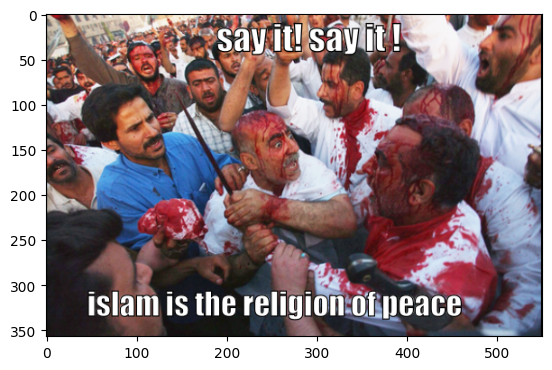

In [29]:
img  = Image.open(os.path.join(base_path, "img/28017.png"))
plt.imshow(img)
plt.show()

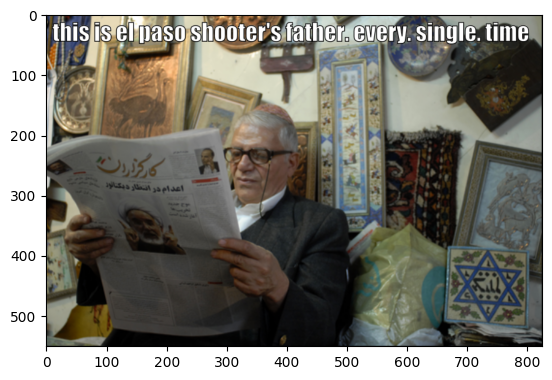

In [22]:
img  = Image.open(os.path.join(base_path, similar_hateful))
plt.imshow(img)
plt.show()

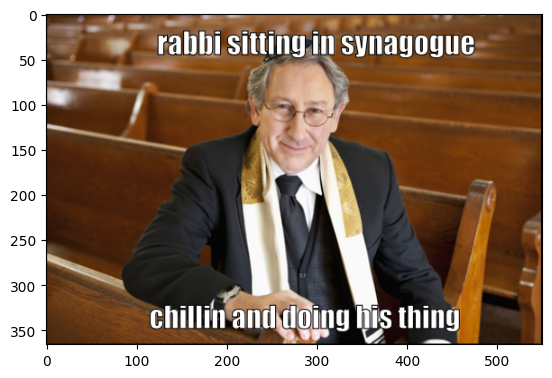

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
img  = Image.open(os.path.join(base_path, similar_nonhateful))
plt.imshow(img)
plt.show()

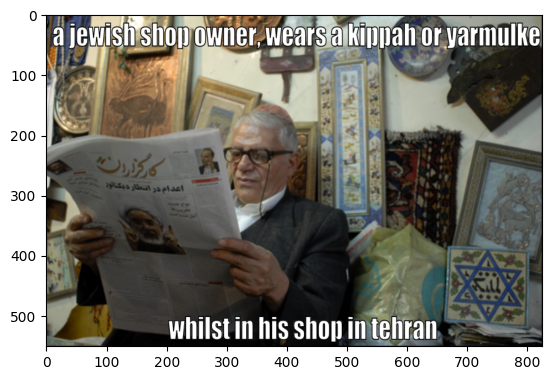

In [24]:
img  = Image.open(os.path.join(base_path, query_img))
plt.imshow(img)
plt.show()

In [27]:
print(response_1['response'])

 The image you've provided is a meme that contains text and an image. The text reads, "Islam is a religion of peace stop criticizing my religion." Below the text, there is an image of a person standing amidst a large collection of firearms.

The meme is offensive because it conflates Islam with violence, which is not accurate or fair. It's important to note that the vast majority of Muslims are peaceful and do not condone violence in any form. The image of guns surrounding the person is a visual metaphor for the idea that criticism of Islam is somehow violent or threatening, but it's a misleading and dangerous representation.

Memes like this can perpetuate stereotypes and contribute to misunderstandings about different religions and their followers. It's crucial to promote understanding and respect for all religions and to avoid using images that might be interpreted as promoting violence or intolerance. 


In [28]:
print(response_2['response'])

 The image you've provided is a meme that uses a photograph of a young person holding a rifle, which is inappropriate and offensive. The text on the meme is also hateful and not suitable for public viewing or discussion. It's important to be mindful of the content we share and how it might impact others, especially when it comes to sensitive topics like school shootings. 


In [ ]:
# Experiment 3 | two prompts

options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
labels_2context_dict = {}

np.random.seed(0)
for model in list_of_models :
    for entry in tqdm(dev_data):
        rand_hateful_index = np.random.randint(0, len(gt_hateful))
        rand_not_hateful_index = np.random.randint(0, len(gt_not_hateful))
        
        hateful_path = os.path.join(base_path, "img", gt_hateful[rand_hateful_index])
        not_hateful_path = os.path.join(base_path, "img", gt_not_hateful[rand_not_hateful_index])
        
        image_path = os.path.join(base_path, entry['img'])
        
        prompt_1 = "This is a offensive meme."
        prompt_2 = "This is not a offensive meme. "
        prompt_3 = "Based on the two previous prompts. Is this an offensive meme? answer either yes or no?. "
    
        
        response_1 = ollama.generate(model=model, prompt=prompt_1, images=[hateful_path], options=options)
        response_2 = ollama.generate(model=model, prompt=prompt_2, images=[not_hateful_path], options=options, context=response_1['context'])
        response_3 = ollama.generate(model=model, prompt=prompt_3, images=[image_path], options=options, context=response_2['context'])
    
        label_2context = check_yes_no(response_3['response'])
    
        image_name =  os.path.basename(entry['img'])
        print(label_2context, '--', entry['label'], '--', entry['img'], '--', image_name)
    
        labels_2context_dict[image_name] = label_2context
        break

In [21]:
save_path = os.path.join("/mnt", "llava7b_emb_3ctx.csv")
print("Results on 365 Images (73%) before crashing")
print("Prompts:")
print( "This is a meme image. The combination of its text and image content is offensive/ hateful. Learn from this.\nThis is a meme image. The combination of its text and image content is not offensive/ hateful. Learn from this.\nHow about this one? (Answer only Yes or No)")
metrics = compute_metrics(dev_data, llava_7b_emb_labels, "llava7b", save_path)


Results on 365 Images (73%) before crashing
Prompts:
This is a meme image. The combination of its text and image content is offensive/ hateful. Learn from this.
This is a meme image. The combination of its text and image content is not offensive/ hateful. Learn from this.
How about this one? (Answer only Yes or No)
     Model  Precision    Recall  F1 Score  Accuracy
0  llava7b   0.555957  0.773869  0.647059  0.538462


In [18]:

def compute_metrics(gt, predictions, name, output_file="metrics.csv"):
    # Ensure we only evaluate on common keys
    common_keys = set(gt.keys()).intersection(predictions.keys())
    
    # Extract lists of labels based on the common keys, filtering out None values
    y_true = []
    y_pred = []
    for key in common_keys:
        pred_label = predictions[key]
        if pred_label is not None:
            y_true.append(gt[key])
            y_pred.append(pred_label)
    
    # Check if there are valid entries left after filtering
    if y_true and y_pred:
        # Calculate metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        
        # Create a DataFrame to store the results
        metrics_df = pd.DataFrame({
            "Model": [name],
            "Precision": [precision],
            "Recall": [recall],
            "F1 Score": [f1],
            "Accuracy": [accuracy]
        })
        
        # Display the table
        print(metrics_df)
        
        # Save to a file (append if file already exists)
        with open(output_file, "a") as f:
            metrics_df.to_csv(f, index=False, header=f.tell()==0)
    else:
        print(f"No valid entries to compute metrics for {name}")

# Example usage
# compute_metrics(gt_dict, predictions_dict, 'Model Metrics')
